# Load Library

In [309]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import wandb
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD
from base.utils.helpers import set_seed, get_activation
from base.model.decoder import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_midgd
from base.dgd.latent import RepresentationLayer
from base.engine.predict import learn_new_representation #, learn_new_representation_mrna
from base.plotting.plot_cv2 import plot_latent_space, plot_gene, plot_mirna

In [18]:
from plotnine import ggplot, aes, labs, geom_jitter, geom_smooth, theme_minimal

In [19]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Load Data

In [20]:
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [21]:
sample_annot = pd.read_table("data/TCGA_sample_anno_iso_match.tsv", sep='\t', index_col=[0])

In [22]:
mirna_annot = pd.read_table("data/TCGA_mirna_anno_iso_match.tsv", sep='\t', index_col=[0])

In [23]:
def data_filtering(df, filter_zero=True, filter_tumor=False):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
        
    return df

# Filter data
tcga_mrna = data_filtering(tcga_mrna_raw)
tcga_mirna = data_filtering(tcga_mirna_raw)

# Shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

# color mapping
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

# make data split for train, validation, and test sets
train_ratio= 0.7

train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type'], random_state=seed) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'], random_state=seed)

# Get the indices of the samples in each split
train_idx = train_mrna.index
val_idx = val_mrna.index
test_idx = test_mrna.index

# Use the same indices to split tcga_mirna
train_mirna = tcga_mirna.loc[train_idx]
val_mirna = tcga_mirna.loc[val_idx]
test_mirna = tcga_mirna.loc[test_idx]

# Train, val, and test data loaders
batch_size = 128

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna, scaling_type='mean')
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna, scaling_type='mean')
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)
data_loader = train_loader, validation_loader, test_loader


In [24]:
print(tcga_mrna.shape)
print(tcga_mirna.shape)

(10676, 19745)
(10676, 2028)


In [25]:
# make data split for train and validation sets
mrna_out_dim = train_mrna.shape[1]-4
mirna_out_dim = train_mirna.shape[1]-4

In [26]:
# Change column name
mirna_column = pd.Series(train_mirna.columns[:-4])

# Convert mirna_annot DataFrame to a dictionary for mapping
mapping_dict = dict(zip(mirna_annot['mature_iso_id'], mirna_annot['mature_iso_name_miRBase']))

# Replace the values in mirna_column using the mapping dictionary
mirna_column = mirna_column.map(mapping_dict).fillna(mirna_column)
mirna_column = np.array(mirna_column)

In [27]:
mirna_column

array(['hsa-let-7a-5p', 'hsa-let-7a-2-3p', 'hsa-let-7b-5p', ...,
       'hsa-miR-3168', 'hsa-miR-3119', 'hsa-miR-6823-3p'], dtype=object)

In [28]:
palette = dict(zip(train_mirna['cancer_type'], train_mirna['color']))

# Load Model

In [14]:
# dgd = torch.load('sweep/oij90mx2_dgd.pickle', map_location=torch.device('cpu'))
# loss_tab = torch.load('sweep/oij90mx2_loss.pickle', map_location=torch.device('cpu'))

In [14]:
# torch.save(dgd, 'models/midgd_final.pt')

In [40]:
# activation = "relu"
# latent_dim = 20
# hidden_dims = [128, 128]
# fc_mirna = 128
# fc_mrna = 1024
# scaling_type = "sum"
# reduction_type = "sum"
# n_tissues = 32
# learning_rates = 1e-4
# weight_decay = 1e-4
# betas = (0.5, 0.7)
# nepochs = 801
# batch_size = 128
# gmm_mean = 5
# sd_mean = 0.2
# r_init = 2
# # Decoder setup
# # set up an output module for the miRNA expression data
# mirna_out_fc = nn.Sequential(
#     nn.Linear(hidden_dims[-1], fc_mirna),
#     get_activation(activation),
#     nn.Linear(fc_mirna, mirna_out_dim))
# output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init, scaling_type=scaling_type)
# output_mirna_layer.n_features = mirna_out_dim

# # set up an output module for the mRNA expression data
# mrna_out_fc = nn.Sequential(
#     nn.Linear(hidden_dims[-1], 128),
#     get_activation(activation),
#     nn.Linear(128, fc_mrna),
#     get_activation(activation),
#     nn.Linear(fc_mrna, mrna_out_dim))
# output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, r_init=r_init, scaling_type=scaling_type)
# output_mrna_layer.n_features = mrna_out_dim

# # set up the decoder
# decoder = Decoder(latent_dim, 
#                   hidden_dims, 
#                   output_module_mirna=output_mirna_layer, 
#                   output_module_mrna=output_mrna_layer, 
#                   activation=activation).to(device)

# # setup gmm init
# gmm_mean_scale = gmm_mean # usually between 2 and 10
# sd_mean_init = sd_mean * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20
# gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}

# # init a DGD model
# dgd = DGD(
#         decoder=decoder,
#         n_mix=n_tissues,
#         rep_dim=latent_dim,
#         gmm_spec=gmm_spec
# )
# # Train Representation Layer Initialization
# Ntrain=len(train_loader.dataset)
# if dgd.train_rep is None:
#     dgd.train_rep = RepresentationLayer(dgd.rep_dim,Ntrain).to(device)

# # Test/Validation Representation Layer Initialization
# Nvalidation=len(validation_loader.dataset)
# if dgd.val_rep is None:
#     dgd.val_rep = RepresentationLayer(dgd.rep_dim,Nvalidation).to(device)

In [29]:
dgd = torch.load('models/midgd_final.pt', map_location=torch.device('cpu'))
# # dgd = torch.load('models/midgd_final.pt')
# dgd.load_state_dict(torch.load('sweep/midgd_d602y281.pt', map_location=torch.device('cpu')))

In [30]:
# new_rep = learn_new_representation(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
# dgd.test_rep = new_rep

In [306]:
def prepare_potential_reps(sample_list):
    """
    takes a list of samples drawn from the DGD's distributions.
    The length gives the number of distributions which defines
    the dimensionality of the output tensor.
    If the list of samples is longer than 1, we will create representations
    from the combination of each GMM's samples.
    """
    return sample_list[0]

def learn_new_representation_mrna(dgd, 
                             data_loader,
                             test_epochs=50,
                             learning_rates=1e-2, 
                             weight_decay=0.,
                             betas=(0.5, 0.7),
                             reduction_type="sum",
                             resampling_type="mean"):
    """
    This function learns a new representation layer for the DGD.
    The new representation layer is learned by sampling new points
    from the GMMs and finding the best fitting GMM for each sample.
    The new representation layer is then optimized to minimize the
    reconstruction loss of the DGD.
    """
    
    gmm_loss = True
    n_samples_new = len(data_loader.dataset)
    potential_reps = prepare_potential_reps([dgd.gmm.sample_new_points(resampling_type)])

    dgd.eval()
    X_mirna, X_mrna = dgd.decoder(potential_reps.to(device))

    rep_init_values = torch.zeros((n_samples_new, potential_reps.shape[-1]))

    for (mrna_data, mirna_data, lib_mrna, lib_mirna, i) in tqdm(data_loader.dataset):
        loss = torch.empty(0).to(device)
        for X in X_mirna:
            mirna_recon_loss = dgd.decoder.loss(
                nn_output=X.to(device), 
                target=mirna_data.to(device), 
                scale=lib_mirna, 
                mod_id="mirna", 
                feature_ids=None, 
                reduction="sum", 
                type="midgd"
            )
            loss = torch.cat((loss, mirna_recon_loss.unsqueeze(0)))
        best_fit_ids = torch.argmin(loss, dim=-1).detach().cpu()
        rep_init_values[i, :] = potential_reps.clone()[best_fit_ids, :]

    Ntest=len(data_loader.dataset)
    new_rep = RepresentationLayer(n_rep=dgd.rep_dim, 
                                  n_sample=Ntest,
                                  value_init=rep_init_values).to(device)
    test_rep_optimizer = torch.optim.AdamW(new_rep.parameters(), lr=learning_rates, weight_decay=weight_decay, betas=betas)

    for epoch in tqdm(range(test_epochs)):
        test_rep_optimizer.zero_grad()
        for (mrna_data, mirna_data, lib_mrna, lib_mirna, index) in data_loader:
            mirna_recon_loss, mrna_recon_loss, gmm_loss = dgd.forward_and_loss(
                z=new_rep(index),
                target=[mirna_data.to(device), mrna_data.to(device)],
                scale=[lib_mirna.unsqueeze(1).to(device), lib_mrna.unsqueeze(1).to(device)], 
                gmm_loss=gmm_loss,
                reduction=reduction_type,
                type="combined"
            )
            loss = mirna_recon_loss + gmm_loss
            loss.backward()
        test_rep_optimizer.step()
    
    return new_rep 


In [310]:
new_rep_mrna = learn_new_representation_mrna(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
dgd.test_rep_mrna = new_rep_mrna

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:47<00:00,  2.16s/it]


In [311]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
    )
    (out_module_mirna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=2024, bias=True)
      )
    )
    (out_module_mrna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
  (test_rep): RepresentationLayer()
  (test_rep_mrna): RepresentationLayer()
)

In [465]:
def plot_latent_space(rep, means, samples, gmm, labels, color_mapping, title="Train", 
                      savedir="plots", filename=None):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["type"] = "Representation"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="white")
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[10,5,30], 
                    edgecolor = "none", alpha=1, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("")
    ax[0].legend(loc='upper right', fontsize='small')
    
    # add explained variance to x-label and y-label for first plot
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")

    # second plot: representations by label
    sns.scatterplot(data=df[df["type"] == "Representation"], x="PC1", y="PC2", hue="label", s=10,
                    edgecolor = "none", alpha=1, ax=ax[1], palette=color_mapping)
    ax[1].set_title("")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3, fontsize='x-small').remove()
    # Create a combined legend for the second subplot
    
    # add explained variance to x-label and y-label for second plot
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")

    # plot
    plt.suptitle(f'PCA of {title}', fontsize=16)
    fig.supxlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=14)
    fig.supylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=14)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=8, markerscale=3, fontsize='medium')

    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

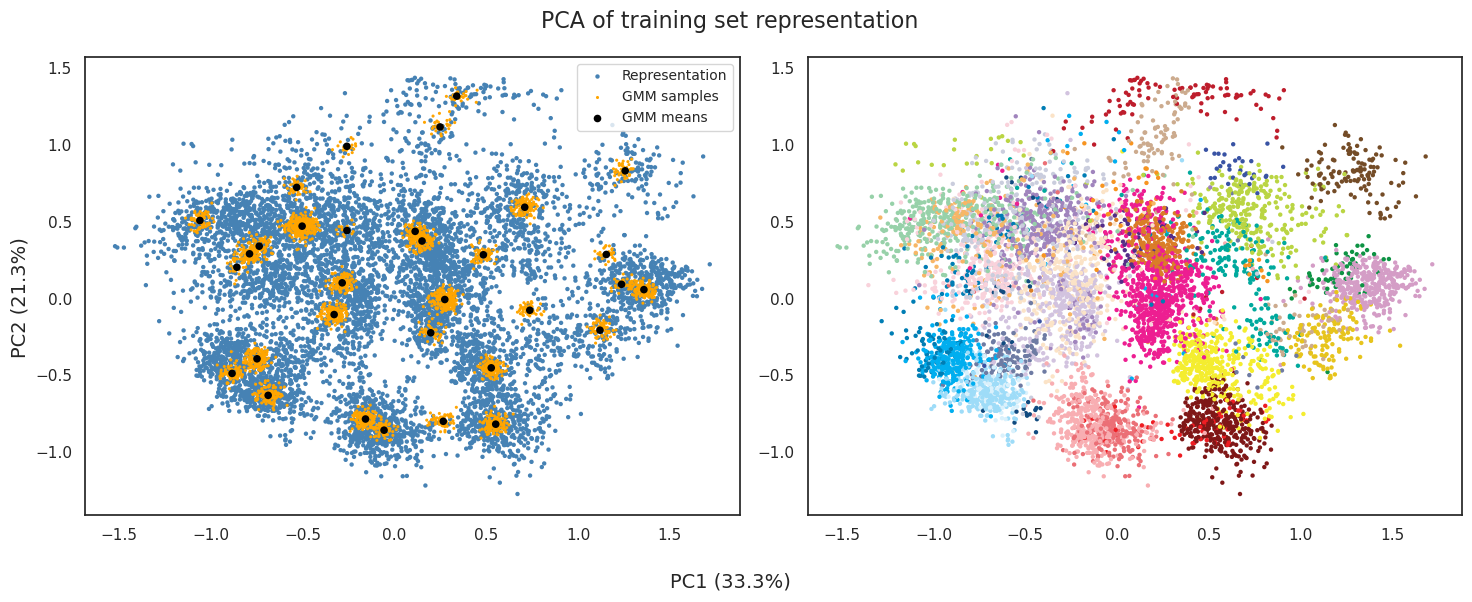

In [463]:
plot_latent_space(*dgd.get_latent_space_values("train",3000), 
                  dgd.gmm, train_loader.dataset.label, 
                  color_mapping, title="training set representation",
                  filename="latent space pca - train.svg")

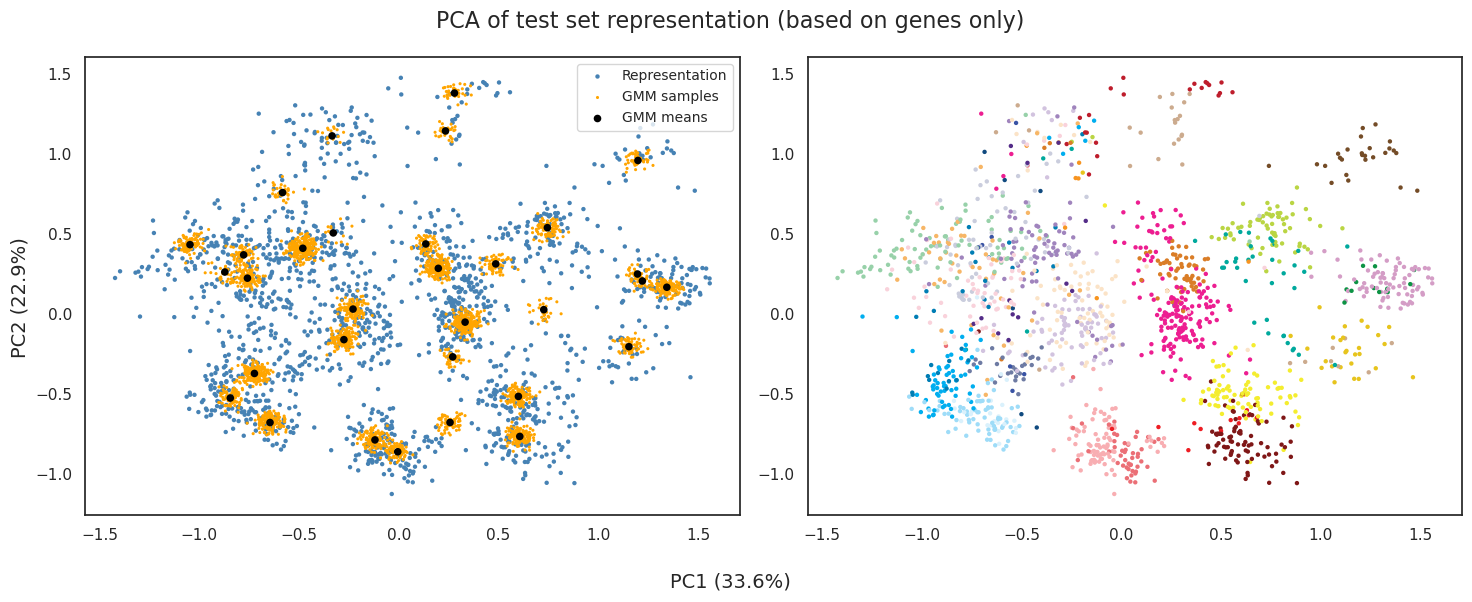

In [464]:
plot_latent_space(*dgd.get_latent_space_values("test",3000), 
                  dgd.gmm, test_loader.dataset.label, 
                  color_mapping, title="test set representation (based on genes only)",
                  filename="latent space pca - test genes.svg")

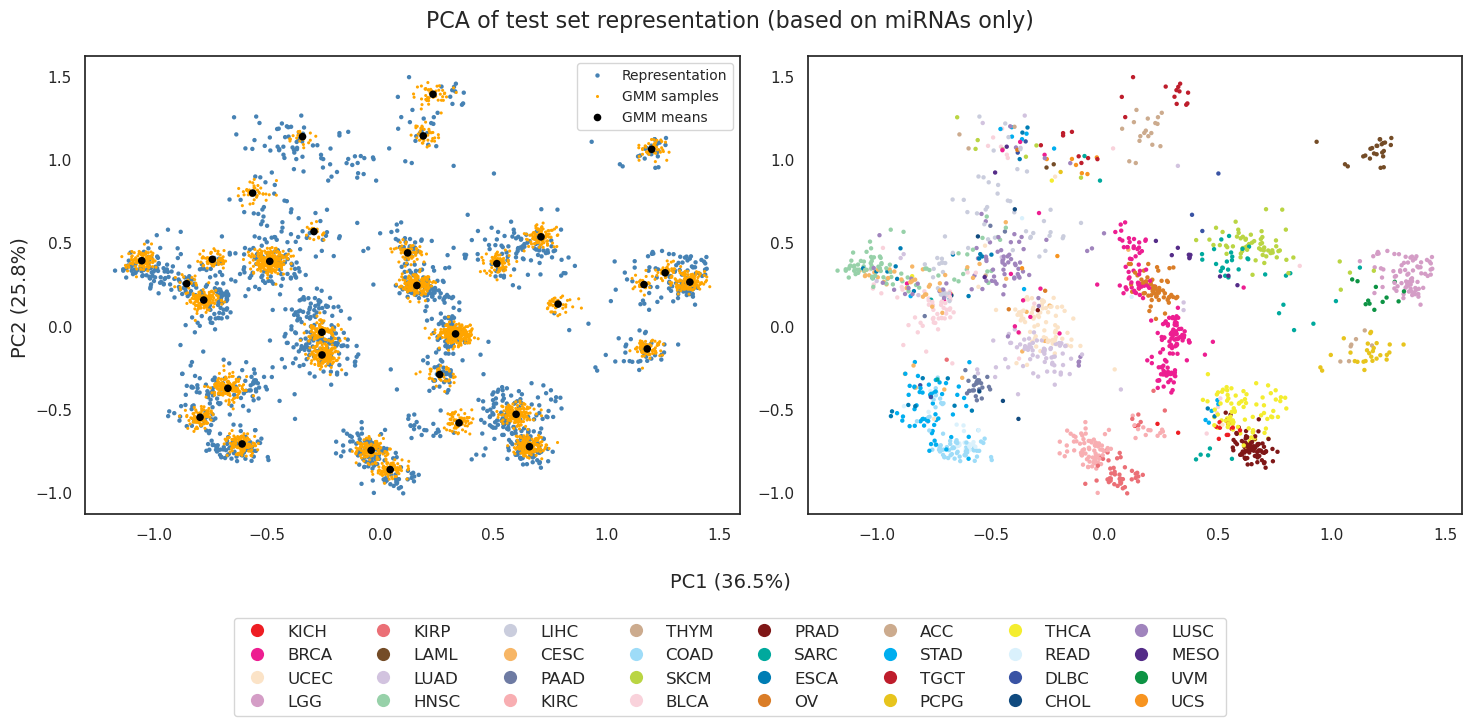

In [466]:
rep = dgd.test_rep_mrna.z.clone().detach().cpu().numpy()
gmm_means = dgd.gmm.mean.clone().detach().cpu().numpy() 
gmm_samples = dgd.gmm.sample(3000).detach().cpu().numpy()

plot_latent_space(rep, gmm_means, gmm_samples, 
                  dgd.gmm, test_loader.dataset.label, 
                  color_mapping, title="test set representation (based on miRNAs only)",
                  filename="latent space pca - test mirna.svg")

# Load and learn sparse data representation

In [351]:
mnt_path = '/home/farzamani/'
project_path = os.path.join(mnt_path, "jsp_student_projects/miRNA_DGD_Farhad_F2024/")
data_path = os.path.join(project_path, "miDGD/data/downsampled/")

In [352]:
sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

mrna_sparse = []
sparse_mrna_test = []

for i, sp in enumerate(sparsity):
    datapath = os.path.join(data_path, f"TCGA_mrna_downsampled_{sp}.tsv")
    print(datapath)
    mrna = pd.read_csv(datapath, sep="\t", index_col=[0])
    mrna_sparse.append(mrna)
    
    mrna_sparse[i] = mrna_sparse[i].reindex(index=tcga_mrna.index, columns=tcga_mrna.columns)
    sparse_mrna_test.append(mrna_sparse[i].loc[test_idx])

torch.save(sparse_mrna_test, "results/sparse_mrna_test.pt")
print("Done!")

/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_1000.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_5000.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_10000.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_50000.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_1e+05.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_5e+05.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_1e+06.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_5e+06.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled

In [353]:
sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

test_datasets = []
test_loaders = []
test_rep_sparse = []
batch_size = 128

sparse_mrna_test = torch.load("results/sparse_mrna_test.pt")

for i, sp in enumerate(sparsity):
    # Train, val, and test data loaders
    dataset = GeneExpressionDatasetCombined(sparse_mrna_test[i], test_mirna, scaling_type='mean')
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size, 
                                         shuffle=False,
                                         num_workers=num_workers)
    test_datasets.append(dataset)
    test_loaders.append(loader)

    test_rep = learn_new_representation(dgd, loader, learning_rates=1e-2, weight_decay=1e-4, test_epochs=20)
    test_rep_sparse.append(test_rep)

torch.save(test_rep_sparse, "results/test_rep.pt")
torch.save(test_loaders, "results/test_loaders.pt")
print("Done!")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.03s/it]


Done!


In [194]:
test_rep_load = torch.load("results/test_rep.pt")
test_loaders = torch.load("results/test_loaders.pt")

## Sparse samples representation

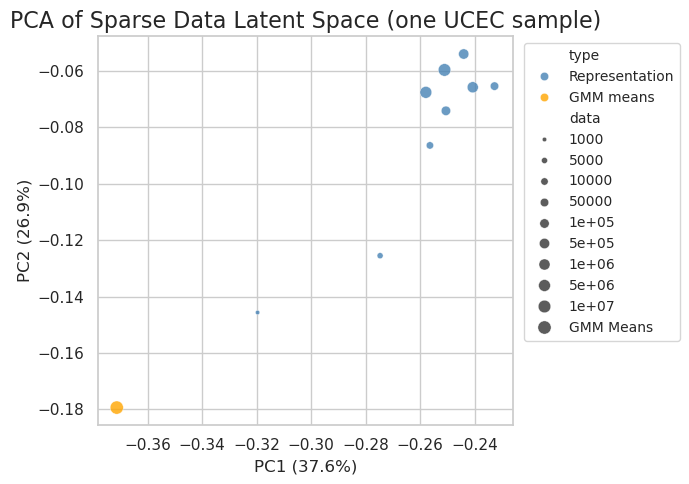

level_0  index       PC1       PC2            type label       data
0        2      2 -0.319639 -0.145679  Representation  UCEC       1000
1     1604      2 -0.274687 -0.125512  Representation  UCEC       5000
2     3206      2 -0.256402 -0.086380  Representation  UCEC      10000
3     4808      2 -0.232700 -0.065346  Representation  UCEC      50000
4     6410      2 -0.250522 -0.074102  Representation  UCEC      1e+05
5     8012      2 -0.244001 -0.053945  Representation  UCEC      5e+05
6     9614      2 -0.240679 -0.065748  Representation  UCEC      1e+06
7    11216      2 -0.257889 -0.067551  Representation  UCEC      5e+06
8    12818      2 -0.251043 -0.059598  Representation  UCEC      1e+07
9       13     13 -0.371335 -0.179417       GMM means   NaN  GMM Means

In [630]:
def plot_latent_space_sparsity(test_rep_load, means, gmm, sparsity, test_loaders, color_mapping, index, dataset="Train", 
                      savedir="plots", filename=None):
    # get PCA
    df_combined = []

    pca = PCA(n_components=2)
    pca.fit(means)
    
    means_pca = pca.transform(means)
    df_gmm = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_gmm['index'] = np.arange(0,32)
    df_gmm["type"] = "GMM means"
    
    for i, sp in enumerate(sparsity):
        rep = test_rep_load[i].z.clone().detach().cpu().numpy()
        rep_pca = pca.transform(rep)
        df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
        df["type"] = "Representation"
        df["label"] = test_loaders[i].dataset.label
        df["data"] = f"{sp}"
        
        df_combined.append(df)
    
    df = pd.concat(df_combined).reset_index()

    # Find index cluster
    for i, sp in enumerate(sparsity):
        rep = test_rep_load[i]
        gmm_cluster = dgd.gmm.clustering(rep(index)).detach().cpu().numpy()
        break

    # Create plotting data
    df_gmm = df_gmm[df_gmm['index'] == gmm_cluster]
    df_gmm['data'] = 'GMM Means'
    df_plot = pd.concat([df[df['index'] == index], df_gmm]).reset_index()
    label = df_plot['label'].iloc[0]
    
    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)    

    # Make Plot
    sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="type", size="data", sizes=(90, 10), alpha=0.8, ax=ax, palette=["steelblue","orange"])
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='small')
    
    # add explained variance to x-label and y-label for first plot
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

    # plot
    plt.title(f'PCA of {dataset} Latent Space (one {label} sample)', fontsize=16)
    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()
    return df_plot

sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

plot_latent_space_sparsity(test_rep_load=test_rep_load, 
                           means=dgd.gmm.mean.clone().detach().cpu().numpy(), 
                           gmm=dgd.gmm,
                           sparsity=sparsity,
                           test_loaders=test_loaders, 
                           color_mapping=color_mapping,
                           index=2,
                           dataset=f"Sparse Data",
                           filename=f"PCA of sparse data latent space.jpeg")

In [726]:
def plot_latent_space_sparsity(test_rep_load, means, gmm, sparsity, test_loaders, color_mapping, gmm_cluster, dataset="Train", 
                      savedir="plots", filename=None):
    # get PCA
    df_combined = []

    pca = PCA(n_components=2)
    pca.fit(means)
    
    means_pca = pca.transform(means)
    df_gmm = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_gmm['index'] = np.arange(0,32)
    df_gmm['type'] = "GMM means"

    df_gmm = df_gmm[df_gmm['index'] == gmm_cluster]
    
    for i, sp in enumerate(sparsity):
        rep = test_rep_load[i].z.clone().detach().cpu().numpy()
        rep_pca = pca.transform(rep)
        df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
        df["type"] = "Representation"
        df["label"] = test_loaders[i].dataset.label
        df["data"] = f"{sp}"
        
        df_combined.append(df)
    
    df = pd.concat(df_combined).reset_index()

    # Find indices belonging to the specified gmm_cluster
    indices = []
    for i, sp in enumerate(sparsity):
        rep = test_rep_load[i]
        cluster_assignments = dgd.gmm.clustering(rep.z).detach().cpu().numpy()
        cluster_indices = np.where(cluster_assignments == gmm_cluster)[0]
        indices = np.random.choice(cluster_indices, 5, replace=False)
        break

    # Create plotting data
    df_gmm = df_gmm[df_gmm['index'] == gmm_cluster]
    df_gmm['data'] = 'GMM Means'
    df_gmm['index'] = 'GMM Means'
    df_plot = pd.concat([df[df['index'].isin(indices)], df_gmm]).reset_index()
    df_plot['index'] = df_plot['index'].astype('category')
    label = df_plot['label'].iloc[0]
    
    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)    

    # Make Plot
    sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="index", style="type", 
                    size="data", sizes=(90, 10), alpha=0.8, ax=ax)
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='x-small')
    
    # add explained variance to x-label and y-label for first plot
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

    # plot
    plt.title(f'PCA of {dataset} Latent Space (samples from cluster {gmm_cluster})', fontsize=16).set_visible(False)
    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

    return df_plot

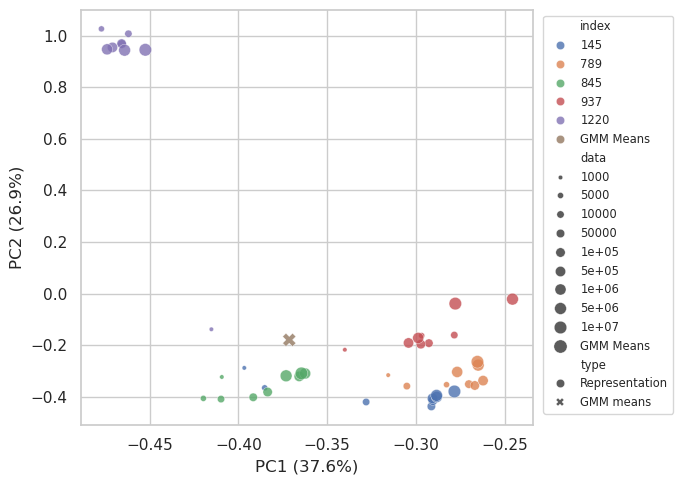

level_0      index       PC1       PC2            type label       data
0       145        145 -0.396665 -0.288193  Representation  UCEC       1000
1       789        789 -0.315617 -0.316213  Representation  UCEC       1000
2       845        845 -0.409323 -0.323424  Representation  UCEC       1000
3       937        937 -0.340034 -0.217818  Representation  UCEC       1000
4      1220       1220 -0.415202 -0.138305  Representation  MESO       1000
5      1747        145 -0.385182 -0.365522  Representation  UCEC       5000
6      2391        789 -0.282759 -0.353349  Representation  UCEC       5000
7      2447        845 -0.419701 -0.406438  Representation  UCEC       5000
8      2539        937 -0.296758 -0.163105  Representation  UCEC       5000
9      2822       1220 -0.477115  1.026824  Representation  MESO       5000
10     3349        145 -0.328032 -0.420309  Representation  UCEC      10000
11     3993        789 -0.305121 -0.358898  Representation  UCEC      10000
12     4049        845 -0.409759 -0.409239  Representation  UCEC      10000
13     4141        937 -0.278384 -0.160958  Representation  UCEC      10000
14     4424       1220 -0.461918  1.007959  Representation  MESO      10000
15     4951        145 -0.291302 -0.437463  Representation  UCEC      50000
16     5595        789 -0.270182 -0.351260  Representation  UCEC      50000
17     5651        845 -0.391623 -0.402109  Representation  UCEC      50000
18     5743        937 -0.292694 -0.192227  Representation  UCEC      50000
19     6026       1220 -0.465557  0.967730  Representation  MESO      50000
20     6553        145 -0.290470 -0.415272  Representation  UCEC      1e+05
21     7197        789 -0.266842 -0.356442  Representation  UCEC      1e+05
22     7253        845 -0.383505 -0.381806  Representation  UCEC      1e+05
23     7345        937 -0.297236 -0.196202  Representation  UCEC      1e+05
24     7628       1220 -0.465758  0.969699  Representation  MESO      1e+05
25     8155        145 -0.290705 -0.406348  Representation  UCEC      5e+05
26     8799        789 -0.262185 -0.337569  Representation  UCEC      5e+05
27     8855        845 -0.365746 -0.321125  Representation  UCEC      5e+05
28     8947        937 -0.304163 -0.191383  Representation  UCEC      5e+05
29     9230       1220 -0.470876  0.955031  Representation  MESO      5e+05
30     9757        145 -0.288269 -0.400855  Representation  UCEC      1e+06
31    10401        789 -0.276767 -0.303935  Representation  UCEC      1e+06
32    10457        845 -0.362396 -0.309960  Representation  UCEC      1e+06
33    10549        937 -0.298727 -0.172175  Representation  UCEC      1e+06
34    10832       1220 -0.473923  0.947457  Representation  MESO      1e+06
35    11359        145 -0.288374 -0.394922  Representation  UCEC      5e+06
36    12003        789 -0.264917 -0.277394  Representation  UCEC      5e+06
37    12059        845 -0.373112 -0.318849  Representation  UCEC      5e+06
38    12151        937 -0.245626 -0.021457  Representation  UCEC      5e+06
39    12434       1220 -0.464071  0.944132  Representation  MESO      5e+06
40    12961        145 -0.278319 -0.379588  Representation  UCEC      1e+07
41    13605        789 -0.265366 -0.264528  Representation  UCEC      1e+07
42    13661        845 -0.364472 -0.309466  Representation  UCEC      1e+07
43    13753        937 -0.277821 -0.038868  Representation  UCEC      1e+07
44    14036       1220 -0.452379  0.945698  Representation  MESO      1e+07
45       13  GMM Means -0.371335 -0.179417       GMM means   NaN  GMM Means

In [734]:
# Example usage
sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

plot_latent_space_sparsity(test_rep_load=test_rep_load, 
                           means=dgd.gmm.mean.clone().detach().cpu().numpy(), 
                           gmm=dgd.gmm,
                           sparsity=sparsity,
                           test_loaders=test_loaders, 
                           color_mapping=color_mapping,
                           gmm_cluster=13,
                           dataset=f"Sparse Data",
                           filename=f"PCA of sparse data latent space.svg")

## PCA

In [594]:
def plot_latent_space_sparse(rep, means, samples, gmm, labels, color_mapping, title="Train", 
                      savedir="plots", filename=None):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["type"] = "Representation"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="white")
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)

    # second plot: representations by label
    sns.scatterplot(data=df[df["type"] == "Representation"], x="PC1", y="PC2", hue="label", s=9,
                    edgecolor = "none", alpha=1, ax=ax, palette=color_mapping)
    ax.set_title("")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3, fontsize='x-small').remove()
    # Create a combined legend for the second subplot
    
    # add explained variance to x-label and y-label for second plot
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=14)
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=14)
    ax.set_title(f'{title}', fontsize=14)
    # ax.set_subtitle(f'{title}', fontsize=14)

    # plot
    # plt.suptitle(f'{title}', fontsize=16)
    # fig.supxlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=14)
    # fig.supylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3, fontsize='medium').remove()

    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

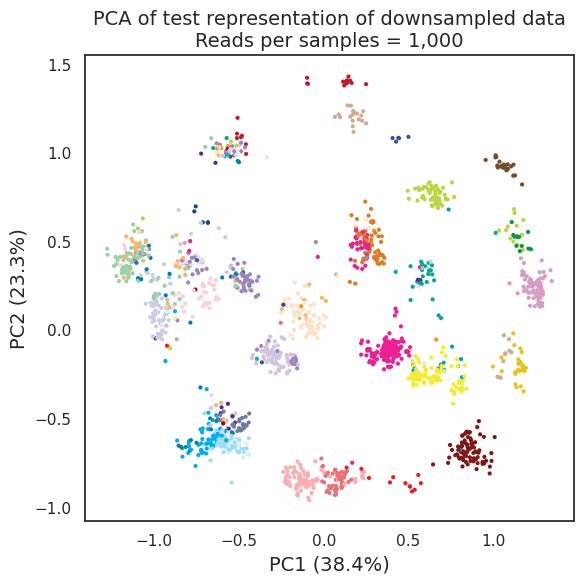

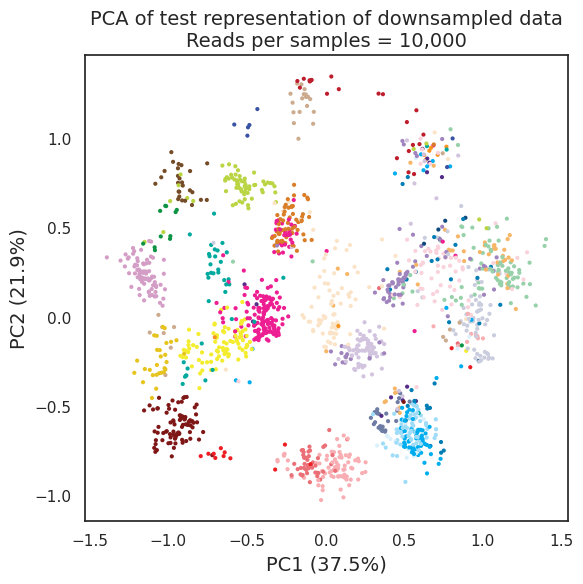

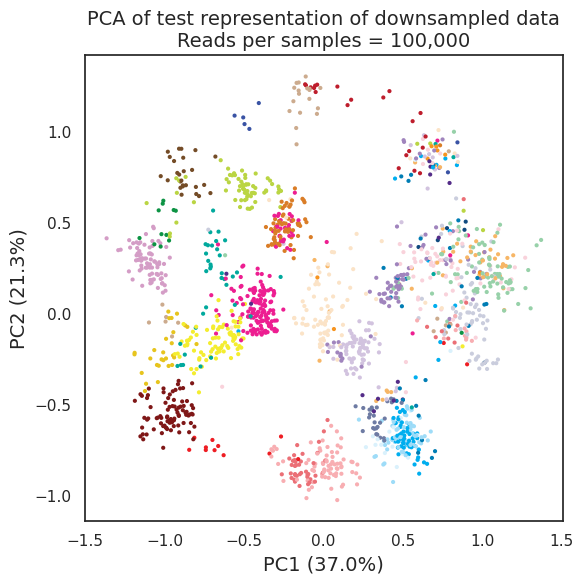

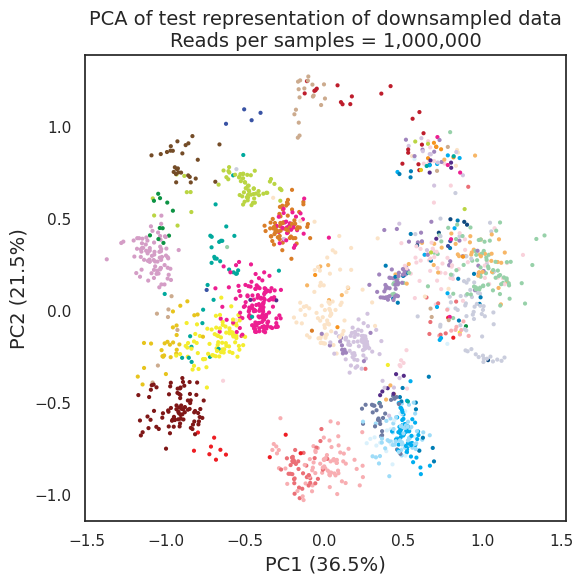

In [595]:
sparsity = ["1,000", "5,000", "10,000", "50,000", "100,000", "500,000", "1,000,000", "5,000,000", "10,000,000"]
# exclude = True
# if exclude:
#     # exclude = ["5,000", "10,000", "50,000", "100,000", "500,000", "1,000,000", "5,000,000", "10,000,000"]
#     # exclude = ["1,000", "5,000", "10,000", "50,000", "100,000", "500,000", "1,000,000", "5,000,000"]
include = ["1,000", "10,000", "100,000", "1,000,000"]
# else:
#     exclude = []
for i, sp in enumerate(sparsity):
    if sp not in include:
        continue
    plot_latent_space_sparse(test_rep_load[i].z.clone().detach().cpu().numpy(), 
                      dgd.gmm.mean.clone().detach().cpu().numpy(), 
                      dgd.gmm.sample(3000).detach().cpu().numpy(), 
                      dgd.gmm, 
                      test_loaders[i].dataset.label, color_mapping, title=f"PCA of test representation of downsampled data\nReads per samples = {sp}",
                      filename=f"pca-test-rep-sparsity-{sp}.svg")

# Generate Analysis Data

In [32]:
def _add_columns(X, y, data_loader):
    X = X.assign(tissue=data_loader.dataset.tissue_type)
    X = X.assign(sample=data_loader.dataset.sample_type)
    X = X.assign(color=data_loader.dataset.color)
    X = X.assign(cancer_type=data_loader.dataset.label)
    
    y = y.assign(tissue=data_loader.dataset.tissue_type)
    y = y.assign(sample=data_loader.dataset.sample_type)
    y = y.assign(color=data_loader.dataset.color)
    y = y.assign(cancer_type=data_loader.dataset.label)
    return X, y

def _get_data_prediction(dgd, data_loader, mirna_column_name, dataset="train"):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        if dataset == "train":
            X, _ = dgd.forward(dgd.train_rep()) 
        elif dataset == "val":
            X, _ = dgd.forward(dgd.val_rep()) 
        elif dataset == "test":
            X, _ = dgd.forward(dgd.test_rep()) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y

def _get_data_pred_from_rep(dgd, test_rep, data_loader, mirna_column_name):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        X, _ = dgd.forward(test_rep.z) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y
    
def generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column_name, subset=False, dataset="test"):
    if subset:
        if dataset == "train":
            X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
            train = pd.DataFrame(
                data={
                    'X': X_train[subset], 
                    'y': y_train[subset],
                    'cancer_type': train_loader.dataset.label,
                    'tissue': train_loader.dataset.tissue_type,
                    'color': train_loader.dataset.color
                }
            )
            return train
        elif dataset == "val":
            X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
            val = pd.DataFrame(
                data={
                    'X': X_val[subset], 
                    'y': y_val[subset],
                    'cancer_type': validation_loader.dataset.label,
                    'tissue': validation_loader.dataset.tissue_type,
                    'color': validation_loader.dataset.color
                }
            )
            return val
        elif dataset == "test":
            X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
            test = pd.DataFrame(
                data={
                    'X': X_test[subset], 
                    'y': y_test[subset],
                    'cancer_type': test_loader.dataset.label,
                    'tissue': test_loader.dataset.tissue_type,
                    'color': test_loader.dataset.color
                }
            )
            return test
    else:
        X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
        X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
        X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
        
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_mirna_data(dgd, data_loader, subset, mirna_column_name=mirna_column, dataset="test"):
    return generate_analysis_data(dgd, *data_loader, mirna_column_name, subset=subset, dataset=dataset)

X_train, y_train, X_val, y_val, X_test, y_test = generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column)

In [492]:
X_test

hsa-let-7a-5p  hsa-let-7a-2-3p  hsa-let-7b-5p  hsa-let-7b-3p  \
0     188165.906250        50.092350   56703.632812     219.648285   
1      46130.644531         8.090611   32939.335938      73.441322   
2     198033.453125        34.404640  124493.429688     222.102661   
3     181759.875000        71.378563   78770.140625     134.466263   
4     180666.765625       109.986549   90353.273438     172.275726   
...             ...              ...            ...            ...   
1597  269312.218750       104.953949  130006.164062     116.877235   
1598  234779.093750        97.719734  134007.281250     241.117004   
1599  189592.218750       305.738525   92405.445312     199.601715   
1600   40551.968750         2.616050   15650.364258      14.593679   
1601  322678.062500        42.193371  173837.390625     156.794220   

      hsa-let-7c-5p  hsa-let-7c-3p  hsa-let-7d-5p  hsa-let-7f-5p  \
0      25999.507812     120.259438    1645.518433   64814.144531   
1       5316.019531      48.668797     170.552368    9758.141602   
2      11046.800781     146.533508    1986.484985   40892.257812   
3      32783.281250     235.952454     780.993347   42618.781250   
4      17417.556641     271.903137    1834.019165   51961.632812   
...             ...            ...            ...            ...   
1597   36179.734375     340.479309    1843.605835   81203.375000   
1598   25708.292969     115.885490    1494.535522   74396.101562   
1599   21355.751953     353.319550    1499.670898   61345.679688   
1600    2700.529785       6.747137     196.177795   15770.541992   
1601   17155.177734      86.279655    5243.904297   79950.460938   

      hsa-let-7f-1-3p  hsa-let-7g-5p  ...  hsa-miR-4681  hsa-miR-4691-5p  \
0           22.793039    5365.328125  ...      0.023010         0.000390   
1            2.813359     542.997192  ...      0.000846         0.000311   
2           15.255520    6160.930176  ...      0.005958         0.030019   
3            5.260205    2562.052734  ...      0.008906         0.001000   
4           26.111320    4885.198730  ...      0.282753         0.569663   
...               ...            ...  ...           ...              ...   
1597        16.258398    6627.609375  ...      0.048561         0.040914   
1598        21.926678    4568.324707  ...      0.109671         0.005869   
1599        18.362967    3961.197021  ...      0.092590         0.038931   
1600         1.575016     752.183655  ...      0.002313         0.000736   
1601        17.950239    8981.601562  ...      0.042390         0.158861   

      hsa-miR-6768-3p  hsa-miR-3168  hsa-miR-3119  hsa-miR-6823-3p  tissue  \
0            0.000288      0.032237      0.022343         0.027576   Tumor   
1            0.000458      0.001669      0.000142         0.001621   Tumor   
2            0.075232      0.035150      0.000773         0.080734   Tumor   
3            0.003858      0.000606      0.002874         0.004587   Tumor   
4            0.374504      0.181709      0.442693         0.402101   Tumor   
...               ...           ...           ...              ...     ...   
1597         0.041299      0.002344      0.012251         0.035383   Tumor   
1598         0.004788      0.018746      0.005907         0.017438  Normal   
1599         0.022725      0.000676      0.575092         0.098163   Tumor   
1600         0.001167      0.000508      0.000089         0.000687   Tumor   
1601         0.087230      0.002309      0.522995         0.263992   Tumor   

                   sample    color  cancer_type  
0           Primary Tumor  #EE1D23         KICH  
1           Primary Tumor  #ED1E91         BRCA  
2           Primary Tumor  #FBE3C7         UCEC  
3           Primary Tumor  #D49DC6          LGG  
4           Primary Tumor  #FBE3C7         UCEC  
...                   ...      ...          ...  
1597        Primary Tumor  #FBE3C7         UCEC  
1598  Solid Tissue Normal  #A084BD         LUSC  
1599        Primary Tumor  #00A99D         SARC 

In [266]:
save = False
if save:
    X_train.to_csv("results/data/xtrain.csv")
    y_train.to_csv("results/data/ytrain.csv")
    X_val.to_csv("results/data/xval.csv")
    y_val.to_csv("results/data/yval.csv")
    X_test.to_csv("results/data/xtest.csv")
    y_test.to_csv("results/data/ytest.csv")

# Exploratory

In [97]:
X_val['tissue'].value_counts()

tissue
Tumor     1507
Normal      94
Name: count, dtype: int64

In [98]:
tissue_mapping = dict(zip(sample_annot['cancer_type'], sample_annot['primary_site']))
tissue_mapping

{'BRCA': 'Breast',
 'LUAD': 'Lung',
 'STAD': 'Stomach',
 'COAD': 'Colorectal',
 'DLBC': 'Lymph Nodes',
 'CHOL': 'Bile Duct',
 'LIHC': 'Liver',
 'PRAD': 'Prostate',
 'KICH': 'Kidney',
 'LAML': 'Bone Marrow',
 'PCPG': 'Adrenal Gland',
 'THYM': 'Thymus',
 'SKCM': 'Skin',
 'SARC': 'Soft Tissue',
 'ACC': 'Adrenal Gland',
 'HNSC': 'Head and Neck',
 'TGCT': 'Testis',
 'PAAD': 'Pancreas',
 'KIRP': 'Kidney',
 'KIRC': 'Kidney',
 'MESO': 'Pleura',
 'THCA': 'Thyroid',
 'LGG': 'Brain',
 'ESCA': 'Esophagus',
 'READ': 'Colorectal',
 'BLCA': 'Bladder',
 'LUSC': 'Lung',
 'UVM': 'Eye',
 'UCS': 'Uterus',
 'UCEC': 'Uterus',
 'CESC': 'Cervix',
 'OV': 'Ovary'}

# Test Latent Space

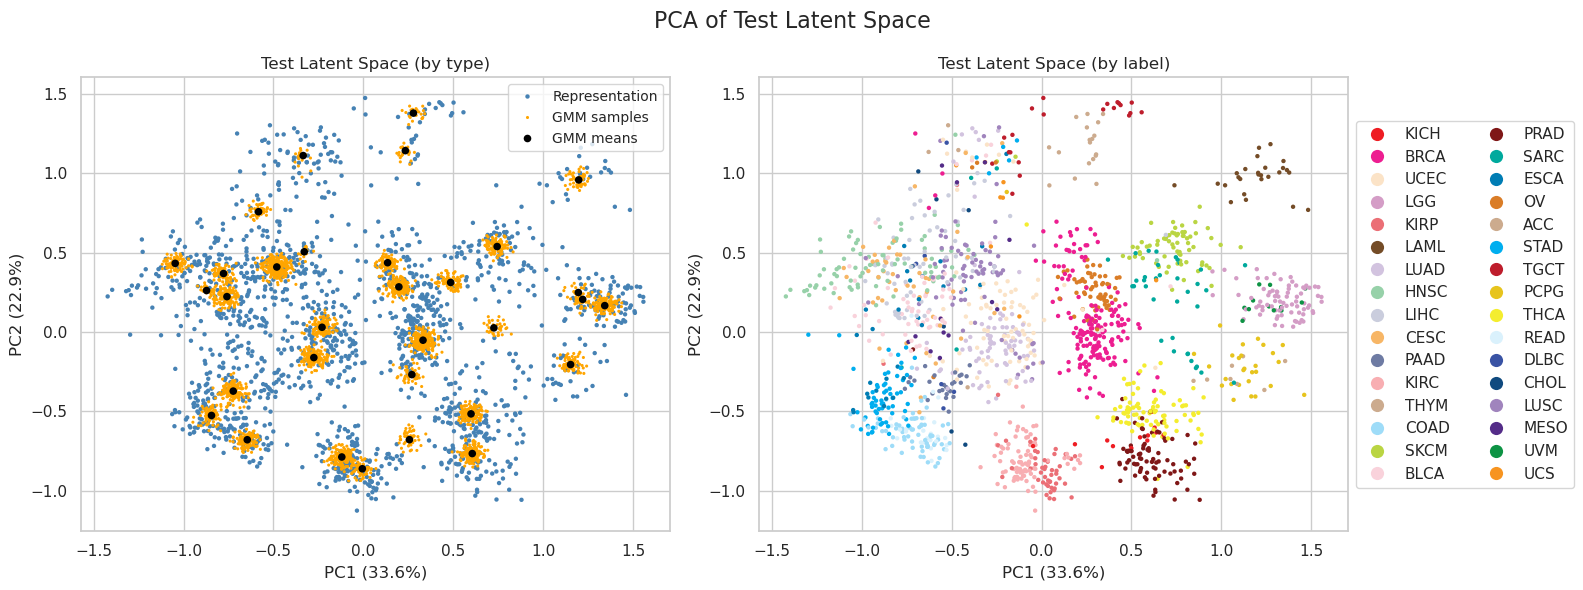

In [99]:
plot_latent_space(*dgd.get_latent_space_values("test",3000), dgd.gmm, test_loader.dataset.label, color_mapping, dataset="Test",
                 filename="PCA of test latent space.pdf")

In [596]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Representation data prep
data = dgd.test_rep.z.detach().numpy()

# Representation data prep
data_mrna = dgd.test_rep_mrna.z.detach().numpy()

# Raw data prep
expression_data = X_test.iloc[:, :-4]

variances = expression_data.var(axis=0)
top_gene = variances.nlargest(200).index
expression_data = expression_data[top_gene]

scaler = StandardScaler()
expression_data = scaler.fit_transform(expression_data)

# PCA Rep
pca = PCA(n_components=2)
pca_result_rep = pca.fit_transform(data)

# PCA Rep mrna
pca = PCA(n_components=2)
pca_result_rep_mrna = pca.fit_transform(data_mrna)

# PCA Raw data
pca = PCA(n_components=2)
pca_result_raw = pca.fit_transform(expression_data)

# tSNE raw data
tsne = TSNE(n_components=2, random_state=42)
tsne_result_raw = tsne.fit_transform(expression_data)

# KMeans
kmeans = KMeans(n_clusters=32, random_state=seed)
cluster_labels_rep = kmeans.fit_predict(pca_result_rep)
cluster_labels_rep_mrna = kmeans.fit_predict(pca_result_rep_mrna)
cluster_labels_raw = kmeans.fit_predict(pca_result_raw)
cluster_labels_tsne = kmeans.fit_predict(tsne_result_raw)

In [597]:
adjusted_rand_score(cluster_labels_rep, test_loader.dataset.label)

0.4253253941123749

In [598]:
adjusted_rand_score(cluster_labels_rep_mrna, test_loader.dataset.label)

0.4459080397876178

In [599]:
adjusted_rand_score(cluster_labels_raw, test_loader.dataset.label)

0.06005814914070679

In [600]:
adjusted_rand_score(cluster_labels_tsne, test_loader.dataset.label)

0.5013803101532281

In [44]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(pca_result, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(pca_result, cluster_labels)
print(f'Davies-Bouldin Index: {db_index}')

# Calculate Calinski-Harabasz Index
ch_index = calinski_harabasz_score(pca_result, cluster_labels)
print(f'Calinski-Harabasz Index: {ch_index}')

Silhouette Score: 0.3940800130367279
Davies-Bouldin Index: 0.8332915395746889
Calinski-Harabasz Index: 2076.1691623702072


In [100]:
def plot_latent_component(dgd, dgd_rep, data_loader, dataset="Test"):
# get PCA

    rep = dgd_rep.z.detach().numpy()
    labels = data_loader.dataset.label
    clustering = []
    
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["label"] = labels
    
    rep = dgd_rep
    for i in range(len(rep.z)):
        cluster = dgd.gmm.clustering(rep(i)).unsqueeze(0).detach().cpu().numpy()
        clustering.extend(cluster)
    df["cluster"] = clustering
    df["cluster"] = df["cluster"].astype('category')
    
    label_counts = df.groupby(['cluster', 'label'], observed=False).size().reset_index(name='counts')
    most_frequent_labels = label_counts.loc[label_counts.groupby('cluster', observed=False)['counts'].idxmax()]
    cluster_to_label = dict(zip(most_frequent_labels['cluster'], most_frequent_labels['label']))
    df['cluster_name'] = df['cluster'].map(cluster_to_label)
    
    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)
    
    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="cluster_name", s=7, alpha=0.8, ax=ax[0], palette=color_mapping)
    ax[0].set_title(str(dataset)+" Latent Space (by GMM Component)")
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    
    # add explained variance to x-label and y-label for first plot
    ax[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    
    # second plot: representations by label
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="label", s=7, alpha=0.8, ax=ax[1], palette=color_mapping)
    ax[1].set_title(str(dataset)+" Latent Space (by Cancer Type)")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    # add explained variance to x-label and y-label for second plot
    ax[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    
    # plot
    plt.suptitle(f'PCA of {dataset} Latent Space Cluster (GMM Component)', fontsize=16)
    plt.tight_layout()
    
    plt.show()

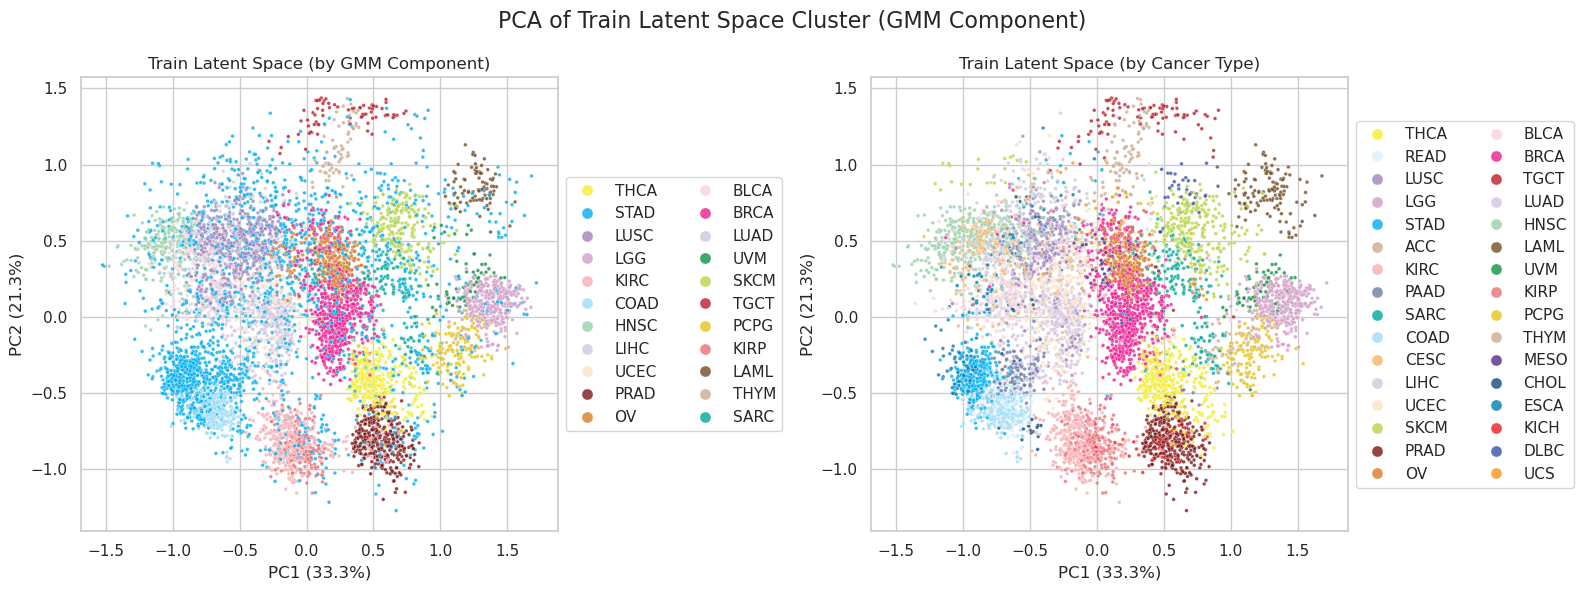

In [101]:
plot_latent_component(dgd, dgd.train_rep, train_loader, dataset="Train")

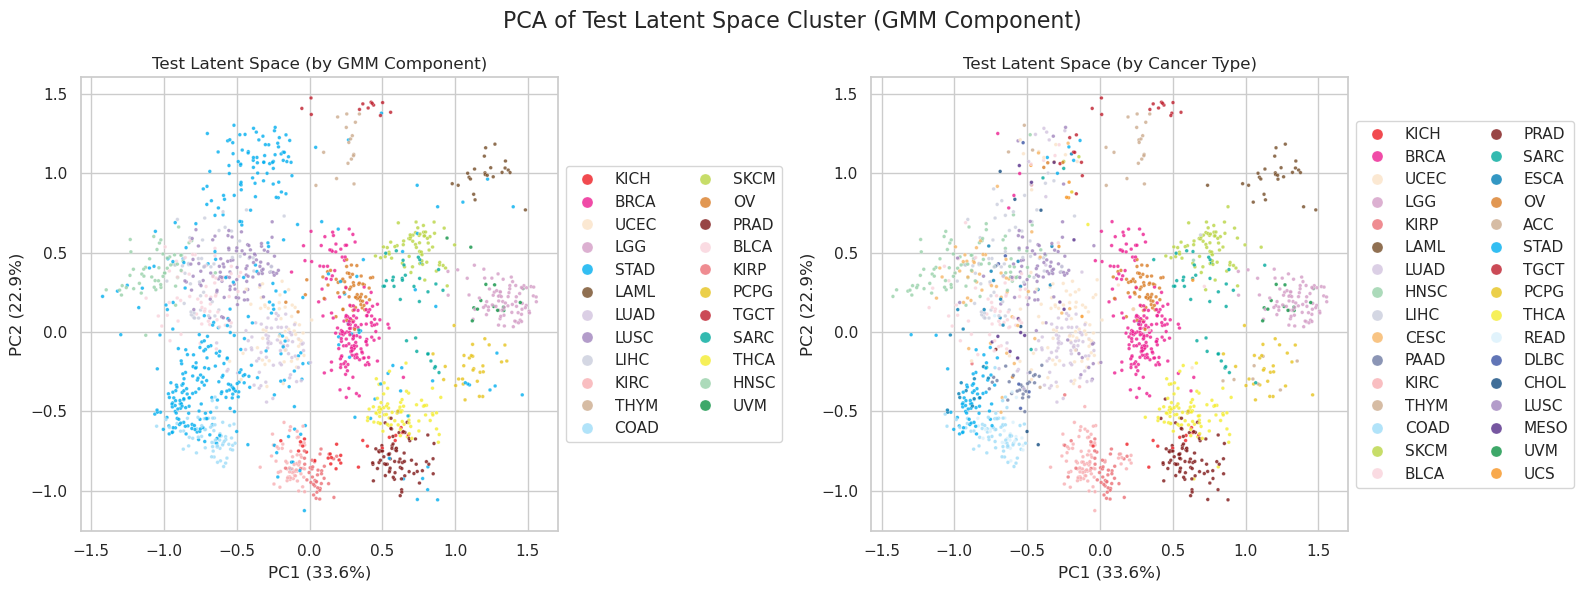

In [102]:
plot_latent_component(dgd, dgd.test_rep, test_loader, dataset="Test")

# Calculate Metrics Measurement

## Rand Index

In [531]:
tissue_mapping

{'BRCA': 'Breast',
 'LUAD': 'Lung',
 'STAD': 'Stomach',
 'COAD': 'Colorectal',
 'DLBC': 'Lymph Nodes',
 'CHOL': 'Bile Duct',
 'LIHC': 'Liver',
 'PRAD': 'Prostate',
 'KICH': 'Kidney',
 'LAML': 'Bone Marrow',
 'PCPG': 'Adrenal Gland',
 'THYM': 'Thymus',
 'SKCM': 'Skin',
 'SARC': 'Soft Tissue',
 'ACC': 'Adrenal Gland',
 'HNSC': 'Head and Neck',
 'TGCT': 'Testis',
 'PAAD': 'Pancreas',
 'KIRP': 'Kidney',
 'KIRC': 'Kidney',
 'MESO': 'Pleura',
 'THCA': 'Thyroid',
 'LGG': 'Brain',
 'ESCA': 'Esophagus',
 'READ': 'Colorectal',
 'BLCA': 'Bladder',
 'LUSC': 'Lung',
 'UVM': 'Eye',
 'UCS': 'Uterus',
 'UCEC': 'Uterus',
 'CESC': 'Cervix',
 'OV': 'Ovary'}

In [532]:
from sklearn.metrics.cluster import rand_score, adjusted_rand_score

def calculate_rand(dgd_rep, data_loader):
    labels = data_loader.dataset.label
    clustering = []
    
    df = pd.DataFrame(labels, columns=["label"])
    
    rep = dgd_rep
    for i in range(len(rep.z)):
        cluster = dgd.gmm.clustering(rep(i)).unsqueeze(0).detach().cpu().numpy()
        clustering.extend(cluster)
    df["cluster"] = clustering
    df["cluster"] = df["cluster"].astype('category')

    label_counts = df.groupby(['cluster', 'label'], observed=False).size().reset_index(name='counts')
    most_frequent_labels = label_counts.loc[label_counts.groupby('cluster', observed=False)['counts'].idxmax()]
    cluster_to_label = dict(zip(most_frequent_labels['cluster'], most_frequent_labels['label']))
    df['cluster_name'] = df['cluster'].map(cluster_to_label)

    rand_index = adjusted_rand_score(df["label"], df["cluster_name"])

    return rand_index

In [533]:
print(calculate_rand(dgd.train_rep, train_loader))

0.3379472358797847


In [534]:
print(calculate_rand(dgd.test_rep, test_loader))

0.45034009345136955


In [529]:
train_mrna.head(1)

ENSG00000186092.4  ENSG00000273547.1  \
TCGA-DO-A2HM-01B-11R-A22L-07                0.0                0.0   

                              ENSG00000187634.11  ENSG00000188976.10  \
TCGA-DO-A2HM-01B-11R-A22L-07               592.0              3982.0   

                              ENSG00000187961.13  ENSG00000187583.10  \
TCGA-DO-A2HM-01B-11R-A22L-07               480.0               413.0   

                              ENSG00000187642.9  ENSG00000188290.10  \
TCGA-DO-A2HM-01B-11R-A22L-07              132.0               128.0   

                              ENSG00000187608.8  ENSG00000188157.14  ...  \
TCGA-DO-A2HM-01B-11R-A22L-07             5676.0             21986.0  ...   

                              ENSG00000205944.11  ENSG00000183795.8  \
TCGA-DO-A2HM-01B-11R-A22L-07                 0.0                0.0   

                              ENSG00000187191.14  ENSG00000205916.11  \
TCGA-DO-A2HM-01B-11R-A22L-07                 0.0                 0.0   

                              ENSG00000185894.8  ENSG00000172288.7  \
TCGA-DO-A2HM-01B-11R-A22L-07                0.0                0.0   

                              tissue_type    sample_type    color  cancer_type  
TCGA-DO-A2HM-01B-11R-A22L-07        Tumor  Primary Tumor  #F4ED2F         THCA  

[1 rows x 19745 columns]

## Average Spearman Corr

In [320]:
def average_correlation(true, pred, method='pearson'):
    """
    # axis 0 for features, axis 1 for samples
    """
    def avg_corr(true, pred, method, axis):
        if method == 'pearson':
            corr = true.corrwith(pred, axis=axis, method=method)
        elif method == 'spearman':
            corr = true.corrwith(pred, axis=axis, method='spearman')
        else:
            raise ValueError("Method must be 'pearson' or 'spearman'")
        
        avg_corr = corr.mean()
        
        return avg_corr

    avg_corr_features = avg_corr(true, pred, method, axis=0)
    avg_corr_samples = avg_corr(true, pred, method, axis=1)

    return avg_corr_features, avg_corr_samples

In [247]:
sparsity = ["1000", "5000", "1e+4", "5e+4", "1e+5", "5e+5", "1e+6", "5e+6", "1e+7"]
corr_sparsity = []
sp_sparsity = []
for i, sp in enumerate(sparsity):
    X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
    corr = average_correlation(X.iloc[:,:-4], y.iloc[:,:-4], method='spearman')
    corr_sparsity.append(corr)
    sp_sparsity.append(sp)
    
df_corr_sparsity = pd.DataFrame(corr_sparsity, columns=["feature", "sample"])
df_corr_sparsity['sparsity'] = sp_sparsity

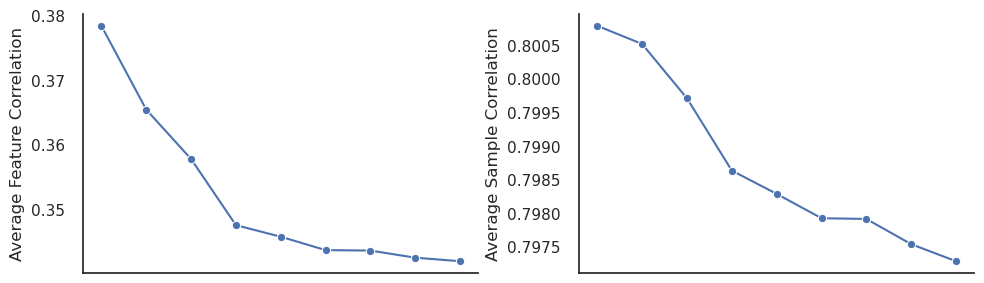

In [618]:
# Set the style
sns.set_style("white")

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plot for feature correlation
sns.lineplot(data=df_corr_sparsity, x='sparsity', y='feature', marker='o', ax=axes[0])
# axes[0].set_title('Average Feature Correlation vs. Sparsity')
axes[0].set_xlabel('')
axes[0].set_ylabel('Average Feature Correlation')
axes[0].tick_params(axis='x', rotation=90, size=14, bottom=False)
axes[0].tick_params(axis='y', size=10)
axes[0].set_xticks([])  # Hide x-ticks

# Plot for sample correlation
sns.lineplot(data=df_corr_sparsity, x='sparsity', y='sample', marker='o', ax=axes[1])
# axes[1].set_title('Average Sample Correlation vs. Sparsity')
axes[1].set_xlabel('')
axes[1].set_ylabel('Average Sample Correlation')
axes[1].tick_params(axis='x', rotation=90, size=14, bottom=False)
axes[1].tick_params(axis='y', size=10)
axes[1].set_xticks([])  # Hide x-ticks

# Adjust layout
plt.tight_layout()
sns.despine()
plt.savefig(os.path.join("plots", "Sparse data spearman corr.svg"))
plt.show()

## RMSE

In [264]:
from sklearn.metrics import root_mean_squared_error

def calculate_rmse(X, y, axis=0):
    rmse_values = []
    X = X.iloc[:, :-4]
    y = y.iloc[:, :-4]
    
    if axis == 0:
        for i in range(y.shape[1]):
            rmse = root_mean_squared_error(X.iloc[:, i], y.iloc[:, i])
            rmse_values.append(rmse)
        
        rmse_data = pd.DataFrame(
            data={  
                'rmse': rmse_values,
                'mirna': X.columns
            },
            index=np.arange(0, len(X.columns))
        )
    elif axis == 1:
        for i in range(y.shape[0]):
            rmse = root_mean_squared_error(X.iloc[i, :], y.iloc[i, :])
            rmse_values.append(rmse)
        
        rmse_data = pd.DataFrame(
            data={  
                'rmse': rmse_values,
                'samples': X.index[:-4]
            },
            index=np.arange(0, len(X.index))
        )
    else:
        raise ValueError("Axis must be 0 (columns) or 1 (rows).")
    
    return rmse_data.sort_values(by='rmse', ascending=True, ignore_index=True)

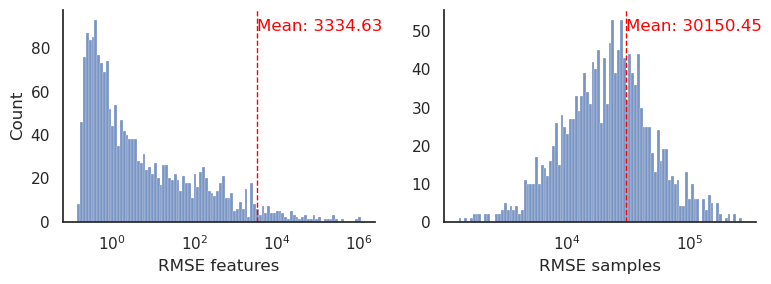

In [415]:
rmse_data_features = calculate_rmse(X_test, y_test, axis=0)
rmse_data_samples = calculate_rmse(X_test, y_test, axis=1)

sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=rmse_data_features, x='rmse', bins=100, log_scale=True)
# plt.title("Spearman's Correlation")
plt.xlabel("RMSE features")
mean_rmse = rmse_data_features['rmse'].mean()
plt.axvline(mean_rmse, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_rmse, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_rmse:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=rmse_data_samples, x='rmse', bins=100, log_scale=True)
# plt.title("Pearson's Correlation")
plt.xlabel("RMSE samples")
plt.ylabel("")
mean_rmse = rmse_data_samples['rmse'].mean()
plt.axvline(mean_rmse, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_rmse, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_rmse:.2f}', color='red')

# Add the main title to the figure
# fig.suptitle("samples correlation histogram", fontsize=16)

# Display the plots
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join("plots", "rmse mirna midgd.pdf"))
plt.show()

In [745]:
rmse_data_features

rmse            mirna
0     1.409882e-01  hsa-miR-6833-5p
1     1.486480e-01     hsa-miR-5688
2     1.543153e-01     hsa-miR-4681
3     1.574181e-01   hsa-miR-574-5p
4     1.588724e-01  hsa-miR-3184-5p
...            ...              ...
2019  2.955466e+05      hsa-miR-375
2020  3.896206e+05   hsa-miR-10b-5p
2021  8.571869e+05   hsa-miR-143-3p
2022  9.870135e+05    hsa-miR-21-5p
2023  1.117168e+06     hsa-miR-9-5p

[2024 rows x 2 columns]

## RMSE Sparse

In [301]:
for i in range(9):
    print(test_loaders[i].dataset.mrna_data[0].sum())

tensor(1000.)
tensor(5000.)
tensor(10000.)
tensor(50000.)
tensor(100000.)
tensor(500000.)
tensor(1000000.)
tensor(5000000.)
tensor(10000000.)


In [620]:
from sklearn.metrics import mean_squared_error
import numpy as np

def average_rmse(true, pred):
    """
    Calculate the average RMSE for features and samples.
    """
    rmse_features = calculate_rmse(true, pred, axis=0)
    rmse_samples = calculate_rmse(true, pred, axis=1)
    rmse_features = rmse_features['rmse'].mean()
    rmse_samples = rmse_samples['rmse'].mean()
    # rmse_features = np.sqrt(mean_squared_error(true, pred, multioutput='raw_values')).mean()
    # rmse_samples = np.sqrt(mean_squared_error(true.T, pred.T, multioutput='raw_values')).mean()
    return rmse_features, rmse_samples


sparsity = ["1000", "5000", "1e+4", "5e+4", "1e+5", "5e+5", "1e+6", "5e+6", "1e+7"]
rmse_sparsity = []
sp_sparsity = []
for i, sp in enumerate(sparsity):
    X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
    rmse = average_rmse(X, y)
    rmse_sparsity.append(rmse)
    sp_sparsity.append(sp)

df_rmse_sparsity = pd.DataFrame(rmse_sparsity, columns=["feature", "sample"])
df_rmse_sparsity['sparsity'] = sp_sparsity

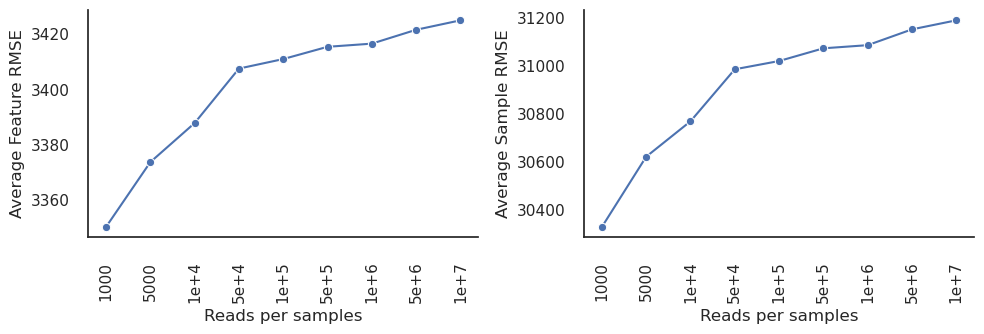

In [621]:
# Set the style
sns.set_style("white")

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

# Plot for feature RMSE
sns.lineplot(data=df_rmse_sparsity, x='sparsity', y='feature', marker='o', ax=axes[0])
axes[0].set_xlabel('Reads per samples')
axes[0].set_ylabel('Average Feature RMSE')
axes[0].tick_params(axis='x', rotation=90, size=14)
axes[0].tick_params(axis='y', size=10)

# Plot for sample RMSE
sns.lineplot(data=df_rmse_sparsity, x='sparsity', y='sample', marker='o', ax=axes[1])
axes[1].set_xlabel('Reads per samples')
axes[1].set_ylabel('Average Sample RMSE')
axes[1].tick_params(axis='x', rotation=90, size=14)
axes[1].tick_params(axis='y', size=10)

# Adjust layout
plt.tight_layout()
sns.despine()
plt.savefig(os.path.join("plots", "Sparse data RMSE.svg"))
plt.show()

# Average correlation based on cancer type

In [62]:
tissue_mapping = dict(zip(sample_annot['cancer_type'], sample_annot['primary_site']))
tissue_mapping

{'BRCA': 'Breast',
 'LUAD': 'Lung',
 'STAD': 'Stomach',
 'COAD': 'Colorectal',
 'DLBC': 'Lymph Nodes',
 'CHOL': 'Bile Duct',
 'LIHC': 'Liver',
 'PRAD': 'Prostate',
 'KICH': 'Kidney',
 'LAML': 'Bone Marrow',
 'PCPG': 'Adrenal Gland',
 'THYM': 'Thymus',
 'SKCM': 'Skin',
 'SARC': 'Soft Tissue',
 'ACC': 'Adrenal Gland',
 'HNSC': 'Head and Neck',
 'TGCT': 'Testis',
 'PAAD': 'Pancreas',
 'KIRP': 'Kidney',
 'KIRC': 'Kidney',
 'MESO': 'Pleura',
 'THCA': 'Thyroid',
 'LGG': 'Brain',
 'ESCA': 'Esophagus',
 'READ': 'Colorectal',
 'BLCA': 'Bladder',
 'LUSC': 'Lung',
 'UVM': 'Eye',
 'UCS': 'Uterus',
 'UCEC': 'Uterus',
 'CESC': 'Cervix',
 'OV': 'Ovary'}

In [177]:
tissue_type = X_test['tissue'].unique()
cancer_type = X_test['cancer_type'].unique()

In [76]:
def average_correlation(true, pred, method='pearson'):
    """
    # axis 0 for features, axis 1 for samples
    """
    def avg_corr(true, pred, method, axis):
        if method == 'pearson':
            corr = true.corrwith(pred, axis=axis, method=method)
        elif method == 'spearman':
            corr = true.corrwith(pred, axis=axis, method='spearman')
        else:
            raise ValueError("Method must be 'pearson' or 'spearman'")
        
        avg_corr = corr.mean()
        
        return avg_corr

    avg_corr_features = avg_corr(true, pred, method, axis=0)
    avg_corr_samples = avg_corr(true, pred, method, axis=1)

    return avg_corr_features, avg_corr_samples

In [94]:
X_train['tissue'] = X_train['cancer_type'].map(tissue_mapping)
y_train['tissue'] = y_train['cancer_type'].map(tissue_mapping)
X_test['tissue'] = X_test['cancer_type'].map(tissue_mapping)
y_test['tissue'] = y_test['cancer_type'].map(tissue_mapping)

In [185]:
cancer_type

array(['KICH', 'BRCA', 'UCEC', 'LGG', 'KIRP', 'LAML', 'LUAD', 'HNSC',
       'LIHC', 'CESC', 'PAAD', 'KIRC', 'THYM', 'COAD', 'SKCM', 'BLCA',
       'PRAD', 'SARC', 'ESCA', 'OV', 'ACC', 'STAD', 'TGCT', 'PCPG',
       'THCA', 'READ', 'DLBC', 'CHOL', 'LUSC', 'MESO', 'UVM', 'UCS'],
      dtype=object)

In [189]:
def average_corr_tissue_specific(X, y, tissue_type, method='pearson', data='Train'):
    corr_tissue = []
    tissues = []
    n_sample = []
    for tissue in tissue_type:
        pred = X[X['tissue'] == tissue]
        true = y[y['tissue'] == tissue]
        pred = pred.iloc[:,:-4]
        true = true.iloc[:,:-4]
        n = pred.shape[0]
        
        corr = average_correlation(true, pred, method)
        corr_tissue.append(corr)
        tissues.append(tissue)
        n_sample.append(n)

    df = pd.DataFrame(corr_tissue, columns=["feature", "sample"])
    df['tissue'] = tissues
    df['n'] = n_sample
    df['dataset'] = data 

    return df.sort_values(by='sample', ascending=False, ignore_index=True)

def average_corr_cancer_specific(X, y, cancer_type, method='pearson', data='Train'):
    corr_cancer = []
    cancers = []
    n_sample = []
    for cancer in cancer_type:
        pred = X[X['cancer_type'] == cancer]
        true = y[y['cancer_type'] == cancer]
        pred = pred.iloc[:,:-4]
        true = true.iloc[:,:-4]
        n = pred.shape[0]
        
        corr = average_correlation(true, pred, method)
        corr_cancer.append(corr)
        cancers.append(cancer)
        n_sample.append(n)

    df = pd.DataFrame(corr_cancer, columns=["feature", "sample"])
    df['cancer_type'] = cancers
    df['n'] = n_sample
    df['dataset'] = data 

    return df.sort_values(by='sample', ascending=False, ignore_index=True)

In [190]:
df_tissue_corr_train = average_corr_tissue_specific(X_train, y_train, tissue_type, method='pearson', data='Train')
df_tissue_corr_test = average_corr_tissue_specific(X_test, y_test, tissue_type, method='pearson', data='Test')
df_tissue_corr = pd.concat([df_tissue_corr_train, df_tissue_corr_test])

In [191]:
df_tissue_corr

feature    sample         tissue    n dataset
0   0.293790  0.838743        Thyroid  400   Train
1   0.331627  0.838247           Skin  316   Train
2   0.319096  0.823801          Liver  294   Train
3   0.319178  0.819652     Colorectal  425   Train
4   0.354849  0.803581        Stomach  312   Train
5   0.381668  0.801303         Testis   97   Train
6   0.375878  0.791286         Breast  825   Train
7   0.307374  0.790688      Esophagus  138   Train
8   0.337813  0.784148        Bladder  295   Train
9   0.295017  0.782064         Thymus   85   Train
10  0.377184  0.777941           Lung  726   Train
11  0.314833  0.776137  Head and Neck  380   Train
12  0.353506  0.773167         Kidney  688   Train
13  0.275454  0.764624         Pleura   61   Train
14  0.306171  0.764145         Cervix  216   Train
15  0.311819  0.751079       Pancreas  128   Train
16  0.298427  0.747561    Soft Tissue  183   Train
17  0.364389  0.746342         Uterus  427   Train
18  0.252575  0.736782       Prostate  382   Train
19  0.312387  0.721075      Bile Duct   32   Train
20  0.302529  0.720119            Eye   56   Train
21  0.282429  0.714603  Adrenal Gland  186   Train
22  0.303661  0.707551    Lymph Nodes   33   Train
23  0.237117  0.654739    Bone Marrow  121   Train
24  0.287780  0.643221          Ovary  298   Train
25  0.318632  0.413507          Brain  369   Train
0   0.222632  0.841677           Skin   68    Test
1   0.164863  0.840823        Thyroid   86    Test
2   0.221299  0.824391          Liver   63    Test
3   0.312452  0.821304         Testis   21    Test
4   0.245344  0.816573     Colorectal   91    Test
5   0.195656  0.799178        Stomach   67    Test
6   0.198394  0.796119         Thymus   18    Test
7   0.161447  0.795297        Bladder   64    Test
8   0.199217  0.793566         Breast  177    Test
9   0.226784  0.781549  Head and Neck   82    Test
10  0.187681  0.777583      Esophagus   29    Test
11  0.189135  0.771200           Lung  156    Test
12  0.234500  0.770593         Kidney  147    Test
13  0.094995  0.765134       Pancreas   27    Test
14  0.095488  0.757139    Lymph Nodes    7    Test
15  0.166987  0.751969         Pleura   13    Test
16  0.288454  0.748759      Bile Duct    6    Test
17  0.143777  0.748662         Cervix   47    Test
18  0.196255  0.742478    Soft Tissue   39    Test
19  0.189026  0.740526         Uterus   91    Test
20  0.150993  0.732878       Prostate   82    Test
21  0.320636  0.729119            Eye   12    Test
22  0.176459  0.720387  Adrenal Gland   40    Test
23  0.139011  0.666083    Bone Marrow   26    Test
24  0.187467  0.613083          Ovary   64    Test
25  0.147824  0.413991          Brain   79    Test

In [186]:
df_cancer_corr_train = average_corr_cancer_specific(X_train, y_train, cancer_type, method='pearson', data='Train')
df_cancer_corr_test = average_corr_cancer_specific(X_test, y_test, cancer_type, method='pearson', data='Test')
df_cancer_corr = pd.concat([df_cancer_corr_train, df_cancer_corr_test])

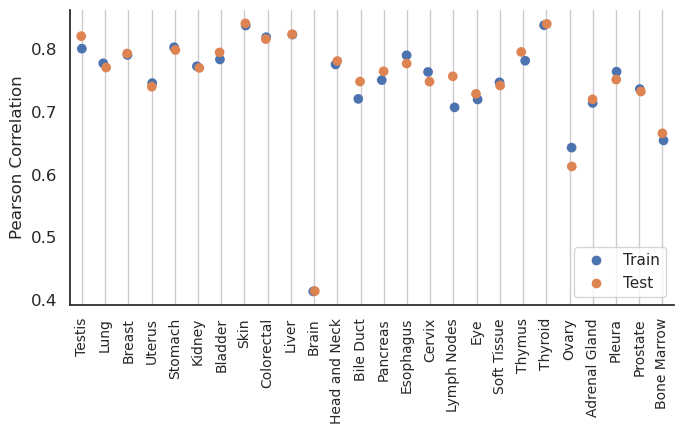

In [176]:
sns.set(style="white")

plt.figure(figsize=(7, 4.5))
ax = sns.stripplot(x="tissue", y="sample", hue="dataset", data=df_tissue_corr, s=7)
plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(True)
plt.ylabel("Pearson Correlation")
plt.xlabel("")
plt.title("")
plt.tick_params(axis='x', labelsize=10)
plt.xticks(rotation=90)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc='lower right') # , bbox_to_anchor=(1, 0.5)

# # Annotate each point
# for i in range(df_tissue_corr.shape[0]):
#     row = df_tissue_corr.iloc[i]
#     ax.annotate(f"{row['sample']:.3f}", (row['tissue'], row['sample']),
#                 textcoords="offset points", xytext=(0, 5), ha='left', size=7)

plt.tight_layout()
sns.despine()
plt.savefig(os.path.join('plots', 'tissue specific corr samples.svg'), bbox_inches='tight')
plt.show()

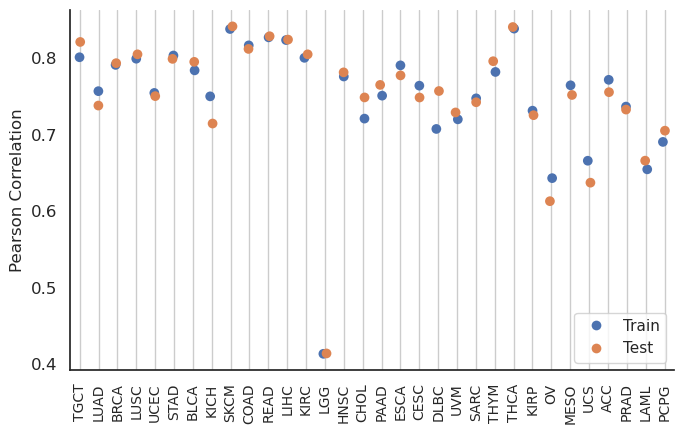

In [187]:
sns.set(style="white")

plt.figure(figsize=(7, 4.5))
ax = sns.stripplot(x="cancer_type", y="sample", hue="dataset", data=df_cancer_corr, s=7)
plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(True)
plt.ylabel("Pearson Correlation")
plt.xlabel("")
plt.title("")
plt.tick_params(axis='x', labelsize=10)
plt.xticks(rotation=90)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc='lower right') # , bbox_to_anchor=(1, 0.5)

# # Annotate each point
# for i in range(df_tissue_corr.shape[0]):
#     row = df_tissue_corr.iloc[i]
#     ax.annotate(f"{row['sample']:.3f}", (row['tissue'], row['sample']),
#                 textcoords="offset points", xytext=(0, 5), ha='left', size=7)

plt.tight_layout()
sns.despine()
plt.savefig(os.path.join('plots', 'cancer specific corr samples.svg'), bbox_inches='tight')
plt.show()

# Top 50 Pearson Correlation

In [14]:
from scipy import stats

def calculate_corr(X, y, axis=0):
    spearman_corr = []
    pearson_corr = []
    spearman_pval = []
    pearson_pval = []
    r2 = []
    r2_pval = []
    X = X.iloc[:,:-4]
    y = y.iloc[:,:-4]
    
    if axis == 0:
        for i in range(y.shape[1]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[:, i], y.iloc[:, i])
            pearson, pearson_p = stats.pearsonr(X.iloc[:, i], y.iloc[:, i])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[:, i], y.iloc[:, i])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.columns
            },
            index=np.arange(0, len(X.columns))
        )
    elif axis == 1:
        for i in range(y.shape[0]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[i, :], y.iloc[i, :])
            pearson, pearson_p = stats.pearsonr(X.iloc[i, :], y.iloc[i, :])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[i, :], y.iloc[i, :])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.index[:-4]
            },
            index=np.arange(0, len(X.index))
        )
    else:
        raise ValueError("Axis must be 0 (columns) or 1 (rows).")
    
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_pearson(X, y, sparsity):
    pearson_corr = []
    pearson_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        pearson, pearson_p = stats.pearsonr(X.iloc[:,i], y.iloc[:,i])
        pearson_corr.append(pearson)
        pearson_pval.append(pearson_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'pearson': pearson_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_spearman(X, y, sparsity):
    spearman_corr = []
    spearman_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        spearman, spearman_p = stats.spearmanr(X.iloc[:,i], y.iloc[:,i])
        spearman_corr.append(spearman)
        spearman_pval.append(spearman_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'spearman': spearman_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='spearman', ascending=False, ignore_index=True)

In [603]:
corr_data_spearman_low = calculate_spearman(X_test, y_test, "Bulk")
corr_data_pearson_low = calculate_pearson(X_test, y_test, "Bulk")

In [604]:
bot_spearman = corr_data_spearman_low.head(10)
bot_pearson = corr_data_pearson_low.head(10)

In [605]:
corr_data_spearman = calculate_spearman(X_test, y_test, "Bulk")
corr_data_pearson = calculate_pearson(X_test, y_test, "Bulk")

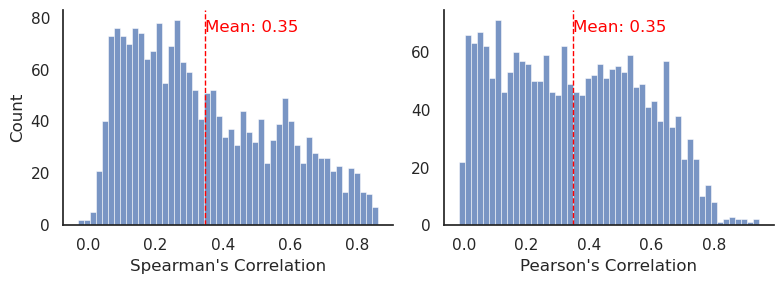

In [40]:
corr_data = calculate_corr(X_test, y_test, axis=0)

sns.set_theme(style="whitegrid")
sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=50)
# plt.title("Spearman's Correlation")
plt.xlabel("Spearman's Correlation")
mean_spearman = corr_data['spearman'].mean()
plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=50)
# plt.title("Pearson's Correlation")
plt.xlabel("Pearson's Correlation")
plt.ylabel("")
mean_pearson = corr_data['pearson'].mean()
plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')

# Add the main title to the figure
# fig.suptitle("samples correlation histogram", fontsize=16)

# Display the plots
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join("plots", "corr mirna midgd feature.svg"))
plt.show()

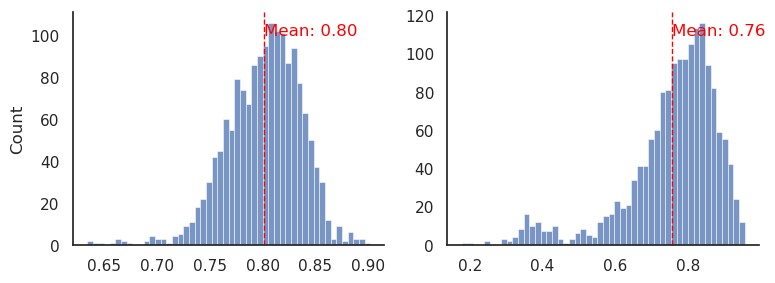

In [41]:
corr_data = calculate_corr(X_test, y_test, axis=1)

sns.set_theme(style="whitegrid")
sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=50)
# plt.title("Spearman's Correlation")
plt.xlabel("Spearman's Correlation").set_visible(False)
mean_spearman = corr_data['spearman'].mean()
plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=50)
# plt.title("Pearson's Correlation")
plt.xlabel("Pearson's Correlation").set_visible(False)
plt.ylabel("")
mean_pearson = corr_data['pearson'].mean()
plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')

# Add the main title to the figure
# fig.suptitle("samples correlation histogram", fontsize=16)

# Display the plots
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join("plots", "corr mirna midgd samples.svg"))
plt.show()

In [114]:
def calculate_corr(X, y, axis=0):
    spearman_corr = []
    pearson_corr = []
    spearman_pval = []
    pearson_pval = []
    r2 = []
    r2_pval = []
    X = X.iloc[:,:-4]
    y = y.iloc[:,:-4]
    
    if axis == 0:
        for i in range(y.shape[1]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[:, i], y.iloc[:, i])
            pearson, pearson_p = stats.pearsonr(X.iloc[:, i], y.iloc[:, i])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[:, i], y.iloc[:, i])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.columns
            },
            index=np.arange(0, len(X.columns))
        )
    elif axis == 1:
        for i in range(y.shape[0]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[i, :], y.iloc[i, :])
            pearson, pearson_p = stats.pearsonr(X.iloc[i, :], y.iloc[i, :])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[i, :], y.iloc[i, :])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.index[:-4]
            },
            index=np.arange(0, len(X.index))
        )
    else:
        raise ValueError("Axis must be 0 (columns) or 1 (rows).")
    
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

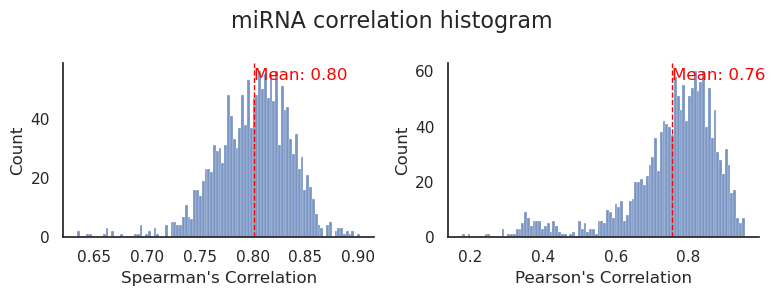

In [116]:
corr_data = calculate_corr(X_test, y_test, axis=1)

sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=100)
# plt.title("Spearman's Correlation")
plt.xlabel("Spearman's Correlation")
mean_spearman = corr_data['spearman'].mean()
plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=100)
# plt.title("Pearson's Correlation")
plt.xlabel("Pearson's Correlation")
mean_pearson = corr_data['pearson'].mean()
plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')

# Add the main title to the figure
fig.suptitle("miRNA correlation histogram", fontsize=16)

# Display the plots
sns.despine()
plt.tight_layout()
# plt.savefig(os.path.join("plots", "corr mirna midgd train.svg"))
plt.show()

In [606]:
top_mirna_spearman = corr_data_spearman.head(50)
top_mirna_pearson = corr_data_pearson.head(50)

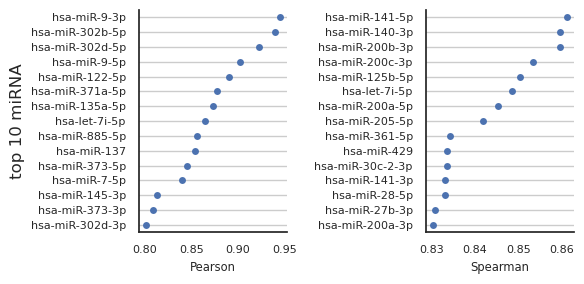

In [233]:
# Assuming top_mirna_pearson and top_mirna_spearman are your DataFrames
sns.set(style="white")  # Set the style to include grid lines

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot the first strip plot for Pearson correlation
ax1 = sns.stripplot(data=top_mirna_pearson, x="pearson", y="mirna", ax=axes[0])
ax1.yaxis.grid(True)
ax1.xaxis.grid(False)  # Optionally, you can turn off vertical grid lines
ax1.set_xlabel("Pearson", fontsize='x-small')
ax1.set_ylabel("top 10 miRNA")
ax1.set_title("")
ax1.tick_params(axis='x', labelsize=8)  # Change x-tick font size
ax1.tick_params(axis='y', labelsize=8)  # Change y-tick font size

# Plot the second strip plot for Spearman correlation
ax2 = sns.stripplot(data=top_mirna_spearman, x="spearman", y="mirna", ax=axes[1])
ax2.yaxis.grid(True)
ax2.xaxis.grid(False)  # Optionally, you can turn off vertical grid lines
ax2.set_xlabel("Spearman", fontsize='x-small')
ax2.set_ylabel("")  # No need to repeat the y-axis label
ax2.set_title("")
ax2.tick_params(axis='x', labelsize=8)  # Change x-tick font size
ax2.tick_params(axis='y', labelsize=8)  # Change y-tick font size

# Adjust layout and remove spines
plt.tight_layout()
sns.despine()

# Show the plot
plt.savefig(os.path.join("plots", "top 15 corr mirna.pdf"), bbox_inches='tight')
plt.show()

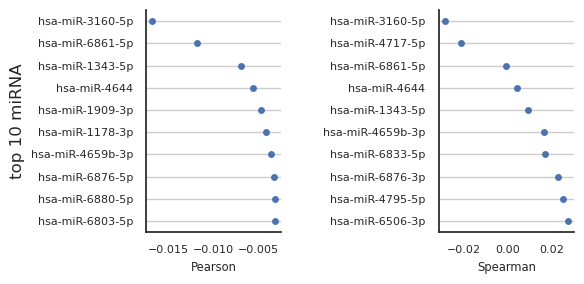

In [323]:
# Assuming top_mirna_pearson and top_mirna_spearman are your DataFrames
sns.set(style="white")  # Set the style to include grid lines

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot the first strip plot for Pearson correlation
ax1 = sns.stripplot(data=bot_pearson, x="pearson", y="mirna", ax=axes[0])
ax1.yaxis.grid(True)
ax1.xaxis.grid(False)  # Optionally, you can turn off vertical grid lines
ax1.set_xlabel("Pearson", fontsize='x-small')
ax1.set_ylabel("bottom 10 miRNA")
ax1.set_title("")
ax1.tick_params(axis='x', labelsize=8)  # Change x-tick font size
ax1.tick_params(axis='y', labelsize=8)  # Change y-tick font size

# Plot the second strip plot for Spearman correlation
ax2 = sns.stripplot(data=bot_spearman, x="spearman", y="mirna", ax=axes[1])
ax2.yaxis.grid(True)
ax2.xaxis.grid(False)  # Optionally, you can turn off vertical grid lines
ax2.set_xlabel("Spearman", fontsize='x-small')
ax2.set_ylabel("")  # No need to repeat the y-axis label
ax2.set_title("")
ax2.tick_params(axis='x', labelsize=8)  # Change x-tick font size
ax2.tick_params(axis='y', labelsize=8)  # Change y-tick font size

# Adjust layout and remove spines
plt.tight_layout()
sns.despine()

# Show the plot
plt.savefig(os.path.join("plots", "bot 15 corr mirna.svg"), bbox_inches='tight')
plt.show()

In [607]:
sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]

pearson_mirna = top_mirna_pearson

for i, sp in enumerate(sparsity):
    X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
    corr = calculate_pearson(X, y, sp)
    mask = corr['mirna'].isin(pearson_mirna['mirna'])
    corr_filtered = corr[mask]
    pearson_mirna = pd.concat([pearson_mirna, corr_filtered])

pearson_mirna

mirna   pearson  sparsity
0       hsa-miR-9-3p  0.945090      Bulk
1    hsa-miR-302b-5p  0.939132      Bulk
2    hsa-miR-302d-5p  0.922107      Bulk
3       hsa-miR-9-5p  0.902062      Bulk
4     hsa-miR-122-5p  0.890401      Bulk
..               ...       ...       ...
103   hsa-miR-194-3p  0.678499  10000000
108  hsa-miR-200b-3p  0.674081  10000000
145   hsa-miR-367-5p  0.654453  10000000
238  hsa-miR-5589-5p  0.609477  10000000
253  hsa-miR-548t-5p  0.604673  10000000

[500 rows x 3 columns]

In [608]:
sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]

spearman_mirna = top_mirna_spearman

for i, sp in enumerate(sparsity):
    X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
    corr = calculate_spearman(X, y, sp)
    mask = corr['mirna'].isin(spearman_mirna['mirna'])
    corr_filtered = corr[mask]
    spearman_mirna = pd.concat([spearman_mirna, corr_filtered])

spearman_mirna

mirna  spearman  sparsity
0    hsa-miR-141-5p  0.861371      Bulk
1    hsa-miR-140-3p  0.859733      Bulk
2   hsa-miR-200b-3p  0.859700      Bulk
3   hsa-miR-200c-3p  0.853475      Bulk
4   hsa-miR-125b-5p  0.850478      Bulk
..              ...       ...       ...
59    hsa-miR-21-3p  0.771212  10000000
62   hsa-miR-218-5p  0.769490  10000000
67   hsa-miR-145-3p  0.762973  10000000
69   hsa-miR-221-3p  0.762475  10000000
75  hsa-miR-203a-3p  0.758909  10000000

[500 rows x 3 columns]

In [314]:
topidx = top_mirna_spearman['mirna'].isin(top_mirna_pearson['mirna'])
top_mirna = list(top_mirna_spearman[topidx]['mirna'])

# GMM Component Clustering

In [225]:
def gmm_clustering(dgd, rep):
    # if dataset == "train":
    #     rep = dgd.train_rep
    # elif dataset == "val":
    #     rep = dgd.val_rep
    # elif dataset == "test":
    #     rep = dgd.test_rep
        
    clustering = []
    for i in range(len(rep.z)):
        cluster = dgd.gmm.clustering(rep(i)).unsqueeze(0).detach().cpu().numpy()
        clustering.extend(cluster)
    clustering = np.array(clustering)
    
    return clustering

test_clustering = gmm_clustering(dgd, dgd.test_rep)
train_clustering = gmm_clustering(dgd, dgd.train_rep)

In [226]:
tissue_mapping

{'BRCA': 'Breast',
 'LUAD': 'Lung',
 'STAD': 'Stomach',
 'COAD': 'Colorectal',
 'DLBC': 'Lymph Nodes',
 'CHOL': 'Bile Duct',
 'LIHC': 'Liver',
 'PRAD': 'Prostate',
 'KICH': 'Kidney',
 'LAML': 'Bone Marrow',
 'PCPG': 'Adrenal Gland',
 'THYM': 'Thymus',
 'SKCM': 'Skin',
 'SARC': 'Soft Tissue',
 'ACC': 'Adrenal Gland',
 'HNSC': 'Head and Neck',
 'TGCT': 'Testis',
 'PAAD': 'Pancreas',
 'KIRP': 'Kidney',
 'KIRC': 'Kidney',
 'MESO': 'Pleura',
 'THCA': 'Thyroid',
 'LGG': 'Brain',
 'ESCA': 'Esophagus',
 'READ': 'Colorectal',
 'BLCA': 'Bladder',
 'LUSC': 'Lung',
 'UVM': 'Eye',
 'UCS': 'Uterus',
 'UCEC': 'Uterus',
 'CESC': 'Cervix',
 'OV': 'Ovary'}

In [244]:
def gmm_clustering_plot(cluster, data_loader, tissue_mapping, is_save=False, savedir="plots", filename=None):
    gmm_comp = pd.DataFrame(
        data={
            'component': cluster,
            'cancer_type': data_loader.dataset.label
        }
    )
    
    # Create dataframe
    df = pd.crosstab(gmm_comp['cancer_type'], gmm_comp['component'])
    df = df.div(df.sum(axis=0))
    df['row_sum'] = df.sum(axis=1)
    df = df.sort_values(by='row_sum', ascending=False)
    df = df.drop(['row_sum'], axis=1)
    
    # Y label
    primary_site_counts = pd.Series(data_loader.dataset.label).value_counts().reset_index()
    primary_site_counts.columns = ['cancer_type', 'count']
    primary_site_counts = primary_site_counts.set_index('cancer_type')
    primary_site_counts = primary_site_counts.loc[df.index]
    primary_site_counts = primary_site_counts.reset_index()
    y_labels = [f"{cancer_type} ({count})" for cancer_type, count in zip(primary_site_counts['cancer_type'], primary_site_counts['count'])]
    
    # X label
    component_counts = pd.Series(cluster).value_counts().sort_index()
    
    # Determine the primary site with the highest count for each component
    primary_site_per_component = df.idxmax(axis=0).map(tissue_mapping)
    x_labels = [f"{primary_site_per_component[component]} ({count})" for component, count in zip(component_counts.index, component_counts.values)]
    
    # Create a heatmap using seaborn
    sns.set_style(style="white")
    plt.subplots(figsize=(16, 10))
    annot = df.map(lambda x: f'{x:.2f}' if x != 0 else '')
    cmap = mpl.colormaps.get_cmap('Blues')
    cmap.set_bad("white")
    g = sns.heatmap(df, annot=annot, mask=False, cmap=cmap, fmt='', linewidth=0.7, annot_kws={'size': 9.5},
                    cbar_kws={'shrink': 0.8, 'label': 'Sample Proportion per Component', 'pad': 0.01})
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    plt.xlabel("GMM components (#samples)", fontsize=12)
    plt.ylabel("Cancer Type (#samples)", fontsize=12)
    g.set_xticklabels(x_labels, fontsize=11, rotation=90)
    g.set_yticklabels(y_labels, fontsize=10.5)
    plt.tight_layout()
    plt.title("Test Dataset", fontsize=16)
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

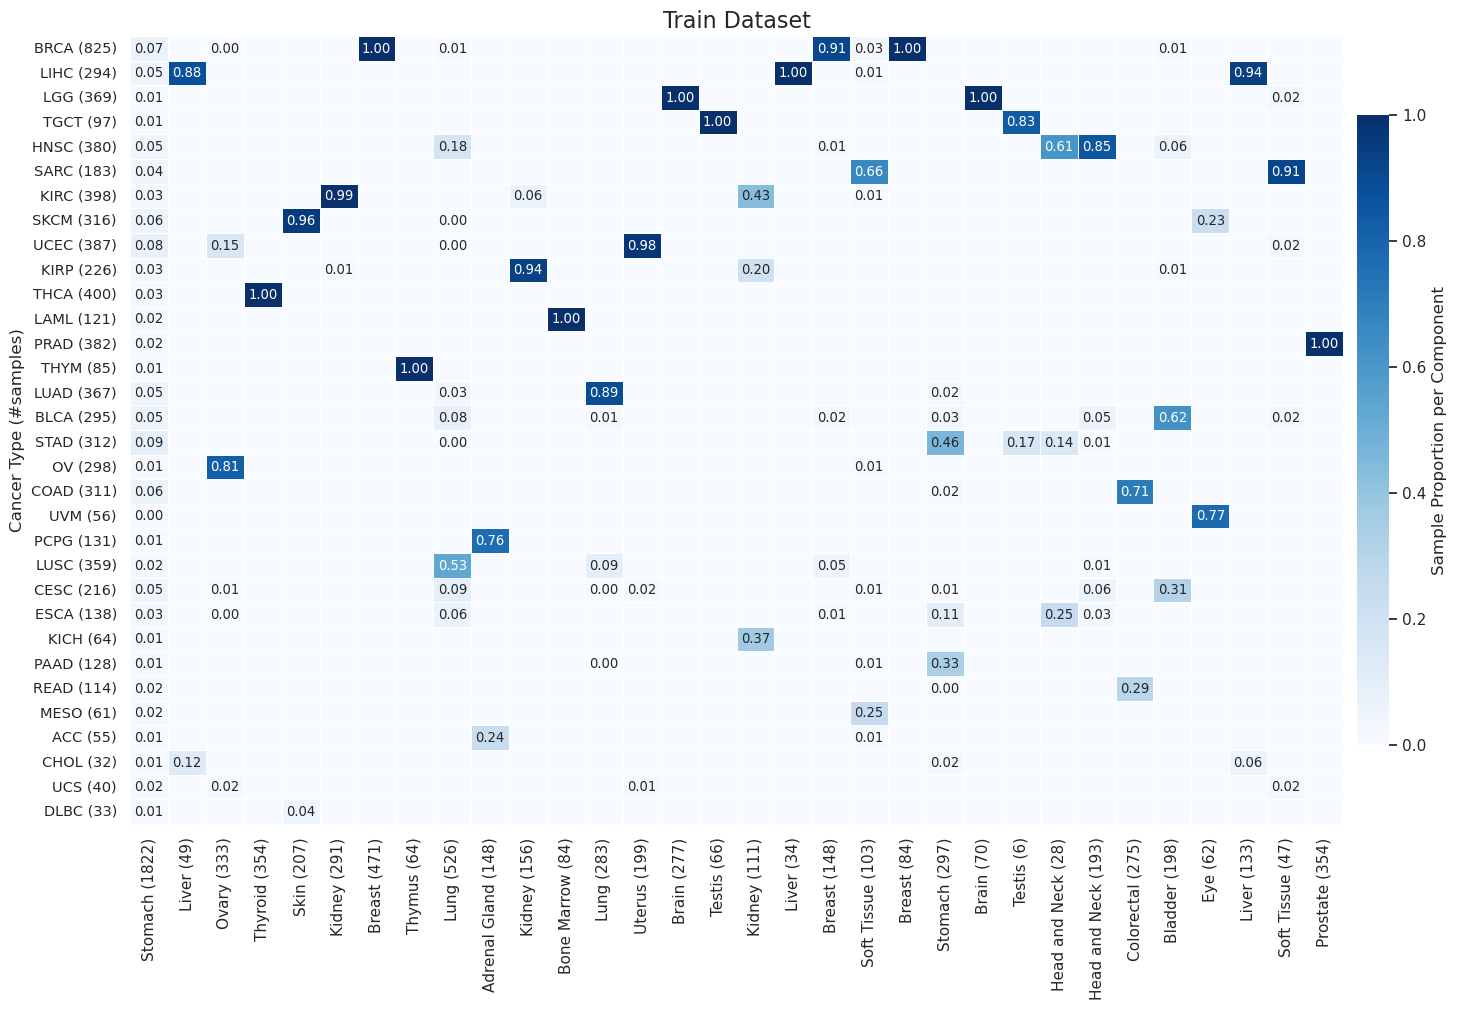

In [240]:
gmm_clustering_plot(train_clustering, train_loader, tissue_mapping, filename="GMM Clustering train data.svg")

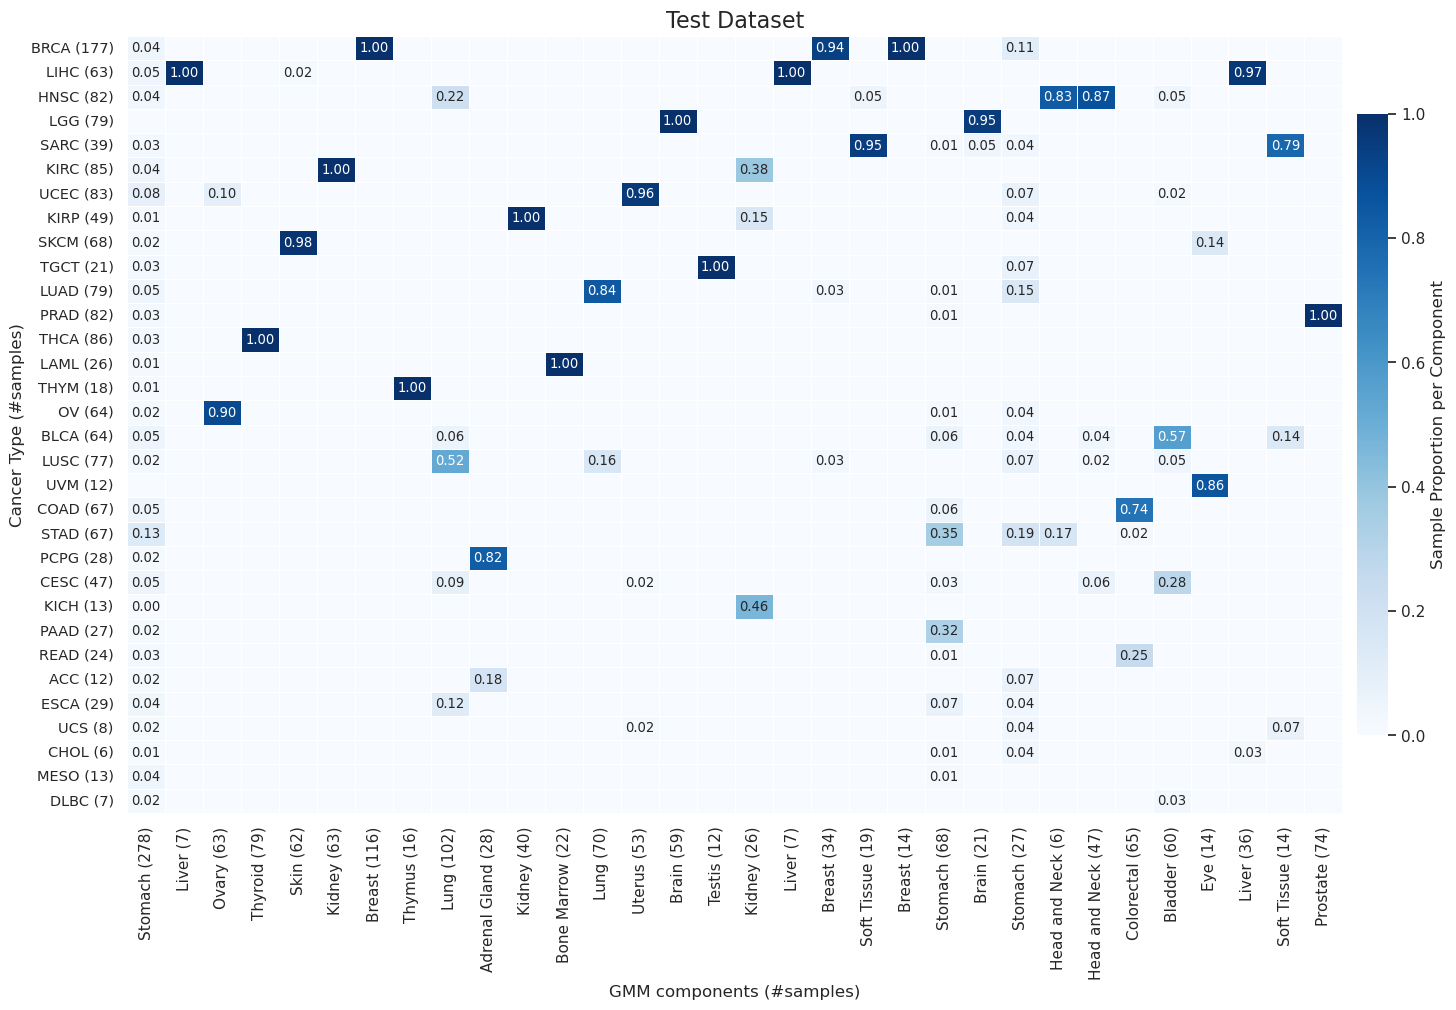

In [245]:
gmm_clustering_plot(test_clustering, test_loader, tissue_mapping, filename="GMM Clustering test data.svg")

AttributeError: 'NoneType' object has no attribute 'remove'

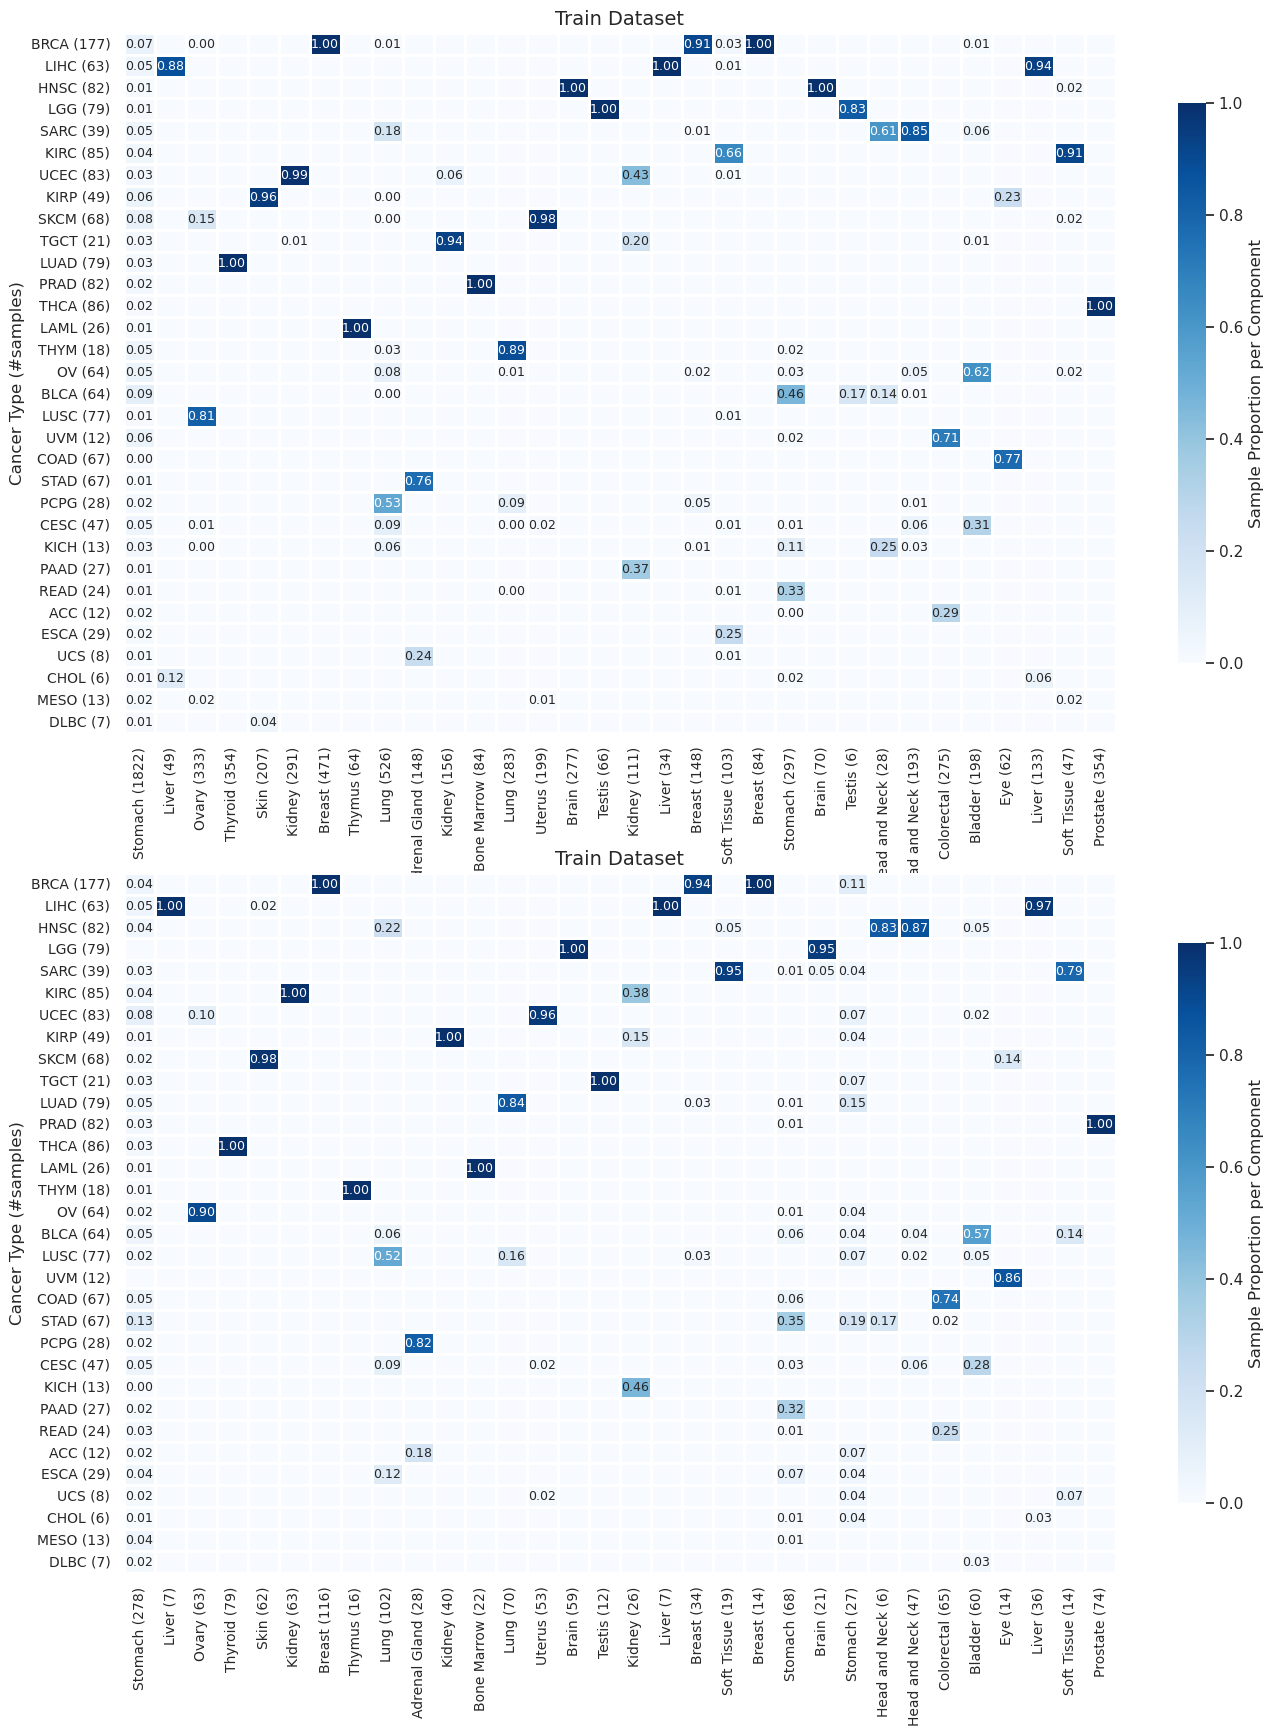

In [563]:
def gmm_clustering_plot(ax, cluster, data_loader, tissue_mapping, show_legend=True):
    gmm_comp = pd.DataFrame(
        data={
            'component': cluster,
            'cancer_type': data_loader.dataset.label
        }
    )
    
    # Create dataframe
    df = pd.crosstab(gmm_comp['cancer_type'], gmm_comp['component'])
    df = df.div(df.sum(axis=0))
    df['row_sum'] = df.sum(axis=1)
    df = df.sort_values(by='row_sum', ascending=False)
    df = df.drop(['row_sum'], axis=1)
    
    # Y label
    primary_site_counts = pd.Series(data_loader.dataset.label).value_counts().reset_index()
    primary_site_counts.columns = ['cancer_type', 'count']
    primary_site_counts = primary_site_counts.set_index('cancer_type')
    primary_site_counts = primary_site_counts.loc[df.index]
    primary_site_counts = primary_site_counts.reset_index()
    y_labels = [f"{cancer_type} ({count})" for cancer_type, count in zip(primary_site_counts['cancer_type'], primary_site_counts['count'])]
    
    # X label
    component_counts = pd.Series(cluster).value_counts().sort_index()
    
    # Determine the primary site with the highest count for each component
    primary_site_per_component = df.idxmax(axis=0).map(tissue_mapping)
    x_labels = [f"{primary_site_per_component[component]} ({count})" for component, count in zip(component_counts.index, component_counts.values)]
    
    # Create a heatmap using seaborn
    sns.set_style(style="white")
    annot = df.map(lambda x: f'{x:.2f}' if x != 0 else '')
    cmap = mpl.colormaps.get_cmap('Blues')
    cmap.set_bad("white")
    g = sns.heatmap(df, annot=annot, mask=False, cmap=cmap, fmt='', linewidth=0.8, annot_kws={'size': 9},
                    cbar_kws={'shrink': 0.8, 'label': 'Sample Proportion per Component'}, ax=ax)
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    ax.set_xlabel("", fontsize=12)
    ax.set_ylabel("Cancer Type (#samples)", fontsize=12)
    g.set_xticklabels(x_labels, fontsize=10, rotation=90)
    g.set_yticklabels(y_labels, fontsize=10)
    ax.set_title("Train Dataset", fontsize=14)
    
    # Remove legend if show_legend is False
    if not show_legend:
        ax.get_legend().remove()

def combined_gmm_clustering_plot(train_clustering, train_loader, test_clustering, test_loader, tissue_mapping, savedir="plots", filename=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20), sharey=True)
    
    # Plot the train data with legend
    gmm_clustering_plot(ax1, train_clustering, train_loader, tissue_mapping, show_legend=True)
    ax1.set_title("Train Dataset", fontsize=14)
    
    # Plot the test data without legend
    gmm_clustering_plot(ax2, test_clustering, test_loader, tissue_mapping, show_legend=False)
    ax2.set_title("Test Dataset", fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure if filename is provided
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    
    # Show the combined plot
    plt.show()

# Example usage
combined_gmm_clustering_plot(train_clustering, train_loader, test_clustering, test_loader, tissue_mapping, filename="GMM_Clustering_combined.svg")

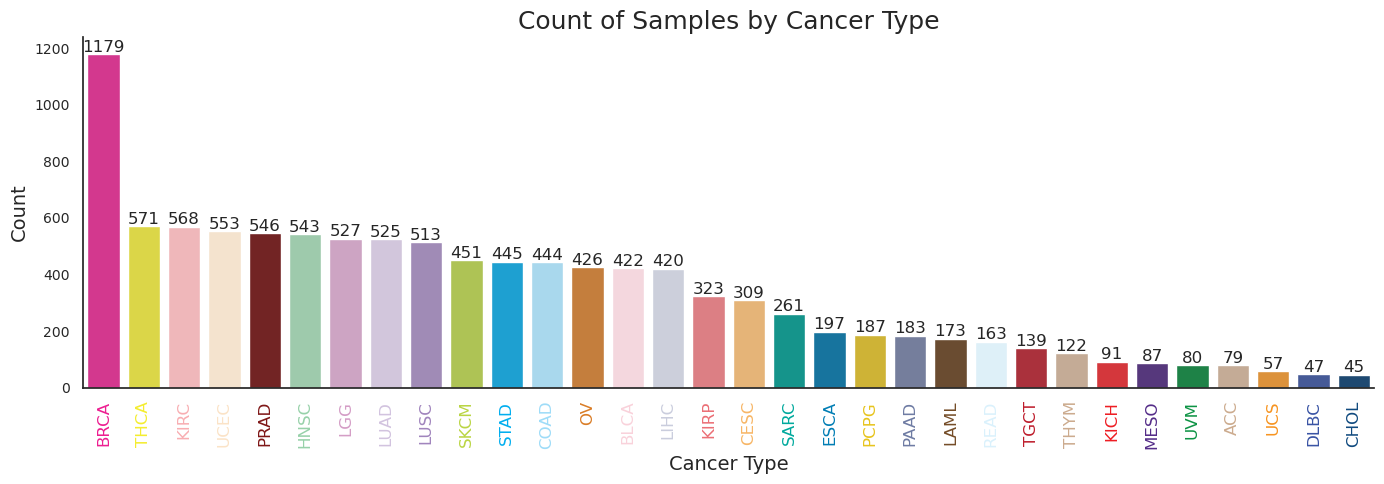

In [172]:
sns.set_style(style="white")
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 5))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Samples by Cancer Type', fontsize=18)
plt.xticks(rotation=90, fontsize=12)  # Rotate the x labels to show them more clearly
plt.yticks(fontsize=10)

for ax in plt.gcf().axes:
    labels = ax.get_xticklabels()
    for label, cancer_type in zip(labels, primary_site_counts['cancer_type'].unique()):
        label.set_color(palette[cancer_type])

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 5),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
sns.despine()
plt.show()

# Dot Plot Top miRNA

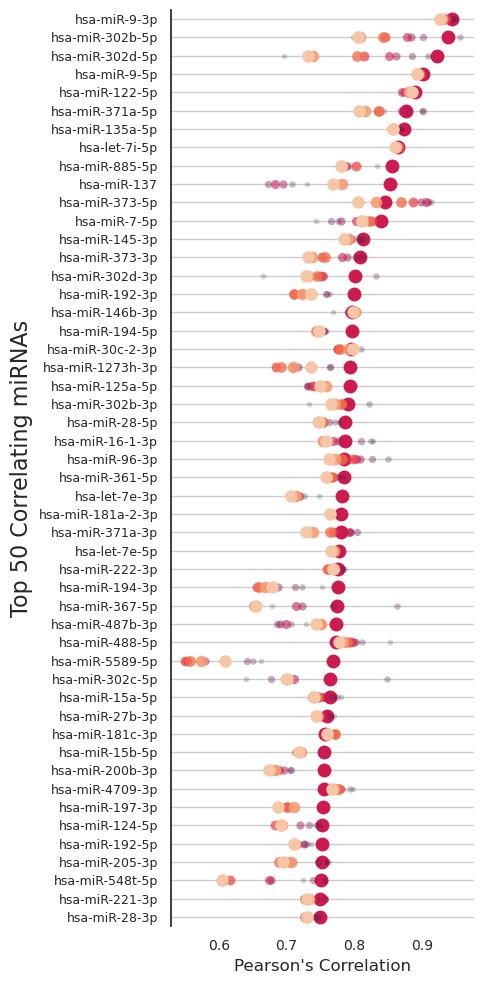

In [614]:
def plot_stripplot_corr_pearson(pearson_mirna, savedir="plots", filename=None):
    # Define the sparsity values
    sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]
    
    # Set the color palette
    palette = sns.color_palette("rocket", n_colors=len(sparsity))
    sns.set_style("white")
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(5, 10))
    
    # Plot the "Bulk" sparsity data
    sns.stripplot(x="pearson", y="mirna", hue="sparsity", data=pearson_mirna[pearson_mirna["sparsity"] == "Bulk"],
                  size=10, alpha=1.0, palette="rocket", ax=ax, dodge=True, legend=False)
    
    # Plot the stripplot for other sparsity values
    for i, sp in enumerate(sparsity):
        # Calculate the size and alpha based on the sparsity value
        size = 4 + (i / (len(sparsity) - 1)) * 5  # Increase size from 3 to 10
        alpha = 0.2 + (i / (len(sparsity) - 1)) * 0.8  # Increase alpha from 0.2 to 1.0
        
        # Plot the data for the current sparsity value
        sns.stripplot(x="pearson", y="mirna", hue="sparsity", data=pearson_mirna[pearson_mirna["sparsity"] == sp],
                      size=size, alpha=alpha, palette=[palette[i]], ax=ax, dodge=True, legend=False)
    
    # Add horizontal grid lines
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    
    # Create custom legend handles for sizes
    size_handles = [plt.Line2D([], [], marker='o', color=palette[i], markersize=4 + (i / (len(sparsity) - 1)) * 5, alpha=0.2 + (i / (len(sparsity) - 1)) * 0.8, label=sp) for i, sp in enumerate(sparsity)]
    bulk_handle = plt.Line2D([], [], marker='o', color=palette[4], markersize=10, alpha=1.0, label='Bulk')
    
    # Combine all handles
    all_handles = size_handles + [bulk_handle]
    
    # Add combined legend
    ax.legend(handles=all_handles, title="Sparsity", loc="upper left", bbox_to_anchor=(1.01, 1), ncol=1, fontsize='10').set_visible(False)
    
    # Adjust plot layout
    plt.subplots_adjust(right=0.8)
    sns.despine(bottom=True)
    plt.xlabel("Pearson's Correlation", fontsize=12)
    plt.ylabel("Top 50 Correlating miRNAs", fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

plot_stripplot_corr_pearson(pearson_mirna, filename="Top 50 Pearson Corr.svg")

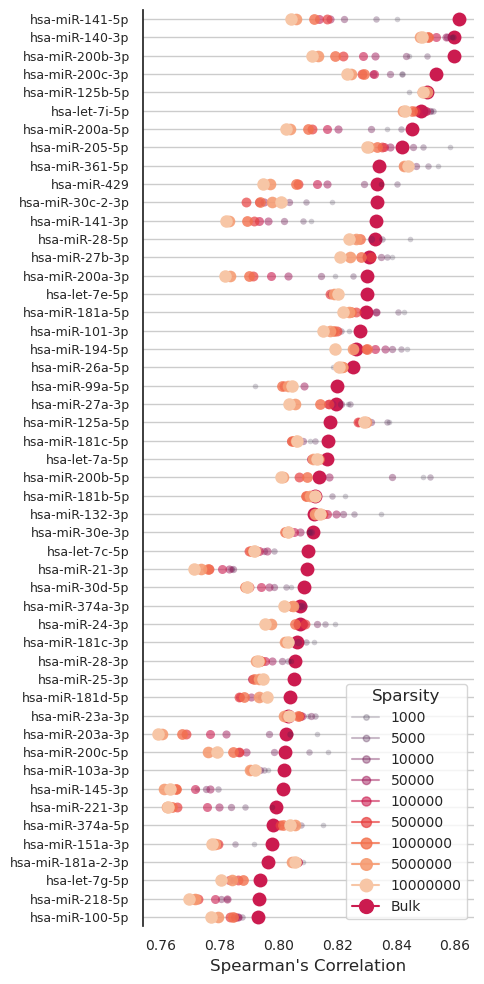

In [613]:
def plot_stripplot_corr_spearman(spearman_mirna, savedir="plots", filename=None):
    # Define the sparsity values
    sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]
    
    # Set the color palette
    palette = sns.color_palette("rocket", n_colors=len(sparsity))
    sns.set_style("white")
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(5, 10))
    
    # Plot the "Bulk" sparsity data
    sns.stripplot(x="spearman", y="mirna", hue="sparsity", data=spearman_mirna[spearman_mirna["sparsity"] == "Bulk"],
                  size=10, alpha=1.0, palette="rocket", ax=ax, dodge=True, legend=False)
    
    # Plot the stripplot for other sparsity values
    for i, sp in enumerate(sparsity):
        # Calculate the size and alpha based on the sparsity value
        size = 4 + (i / (len(sparsity) - 1)) * 5  # Increase size from 3 to 10
        alpha = 0.2 + (i / (len(sparsity) - 1)) * 0.8  # Increase alpha from 0.2 to 1.0
        
        # Plot the data for the current sparsity value
        sns.stripplot(x="spearman", y="mirna", hue="sparsity", data=spearman_mirna[spearman_mirna["sparsity"] == sp],
                      size=size, alpha=alpha, palette=[palette[i]], ax=ax, dodge=True, legend=False)
    
    # Add horizontal grid lines
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    
    # Create custom legend handles for sizes
    size_handles = [plt.Line2D([], [], marker='o', color=palette[i], markersize=4 + (i / (len(sparsity) - 1)) * 5, alpha=0.2 + (i / (len(sparsity) - 1)) * 0.8, label=sp) for i, sp in enumerate(sparsity)]
    bulk_handle = plt.Line2D([], [], marker='o', color=palette[4], markersize=10, alpha=1.0, label='Bulk')
    
    # Combine all handles
    all_handles = size_handles + [bulk_handle]
    
    # Add combined legend
    ax.legend(handles=all_handles, title="Sparsity", loc="lower right", ncol=1, fontsize='10')
    
    # Adjust plot layout
    plt.subplots_adjust(right=0.8)
    sns.despine(bottom=True)
    plt.xlabel("Spearman's Correlation", fontsize=12)
    plt.ylabel("Top 50 Correlating miRNAs", fontsize=16).set_visible(False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

plot_stripplot_corr_spearman(spearman_mirna, filename="Top 50 Spearman Corr.svg")

In [482]:
top_pearson = ['hsa-miR-9-3p', 'hsa-miR-302b-5p', 'hsa-miR-122-5p', 'hsa-miR-7-5p', 'hsa-miR-135a-5p', 'hsa-miR-514a-3p']
top_pearson_cancer = ['LGG', 'TGCT', 'LIHC', 'PCPG', 'THCA', 'SKCM']
top_spearman = ['hsa-miR-141-5p', 'hsa-miR-140-3p', 'hsa-miR-200c-3p', 'hsa-miR-200c-3p', 'hsa-miR-125b-5p']

# True vs predicted miRNA grouped by cancer type

In [306]:
def plot_jitter_grouped_cancer(subset):
    data = get_mirna_data(dgd, data_loader, subset=subset)
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    plt.subplot(2, 1, 1)
    sns.boxplot(data=data, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.5), showfliers=False)
    sns.stripplot(data=data, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
    plt.title("")
    plt.xlabel("")
    plt.ylabel("True expression", fontsize=11)
    plt.xticks([], [])
    
    plt.subplot(2, 1, 2)
    sns.boxplot(data=data, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=.5), showfliers=False)
    sns.stripplot(data=data, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
    plt.title("")
    plt.xlabel("Cancer Type", fontsize=14)
    plt.ylabel("Predicted expression", fontsize=11)
    plt.xticks(rotation=90, fontsize=12)

    for ax in plt.gcf().axes:
        labels = ax.get_xticklabels()
        for label, cancer_type in zip(labels, data['cancer_type'].unique()):
            label.set_color(palette[cancer_type])
    
    plt.suptitle(f"{subset} expression", fontsize=18)
    sns.despine(bottom=True)
    plt.tight_layout()
    plt.show()

In [531]:
from sklearn.metrics import root_mean_squared_error

def plot_jitter_grouped_tissue(subset, savedir="plots", filename=None):
    data = get_mirna_data(dgd, data_loader, subset=subset)

    # Calculate RMSE
    rmse = root_mean_squared_error(data['y'], data['X'])
    
    sns.set_style("white")
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=False)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    sns.boxplot(data=data, x="cancer_type", y="y", hue="tissue", boxprops=dict(alpha=.3), showfliers=False, ax=axes[0])
    sns.stripplot(data=data, x="cancer_type", y="y", hue="tissue", alpha=0.8, zorder=0, ax=axes[0])
    axes[0].set_title("")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("True expression", fontsize=12)
    axes[0].set_xticks([])
    axes[0].tick_params(axis='y', labelsize=10)
    axes[0].legend(fontsize=8)

    # Annotate RMSE
    axes[0].text(0.01, 0.95, f'RMSE: {rmse:.2f}', 
                 horizontalalignment='left', 
                 verticalalignment='top', 
                 transform=axes[0].transAxes, 
                 fontsize=12, 
                 bbox=dict(facecolor='white', alpha=0.5))
    
    sns.boxplot(data=data, x="cancer_type", y="X", hue="tissue", boxprops=dict(alpha=.3), showfliers=False, ax=axes[1])
    sns.stripplot(data=data, x="cancer_type", y="X", hue="tissue", alpha=0.9, zorder=0, ax=axes[1])
    axes[1].set_title("")
    axes[1].set_xlabel("Cancer Type", fontsize=12)
    axes[1].set_ylabel("Predicted expression", fontsize=12)
    axes[1].tick_params(axis='x', rotation=90, labelsize=12)
    axes[1].tick_params(axis='y', labelsize=10)
    axes[1].legend(fontsize=8).remove()

    # Ensure x-tick labels are colored correctly
    for ax in axes:
        labels = ax.get_xticklabels()
        for label, cancer_type in zip(labels, data['cancer_type'].unique()):
            label.set_fontweight('normal')
            label.set_color(palette[cancer_type])
            
    fig.suptitle(f"{subset} expression", fontsize=14, y=0.95)
    sns.despine(bottom=False)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

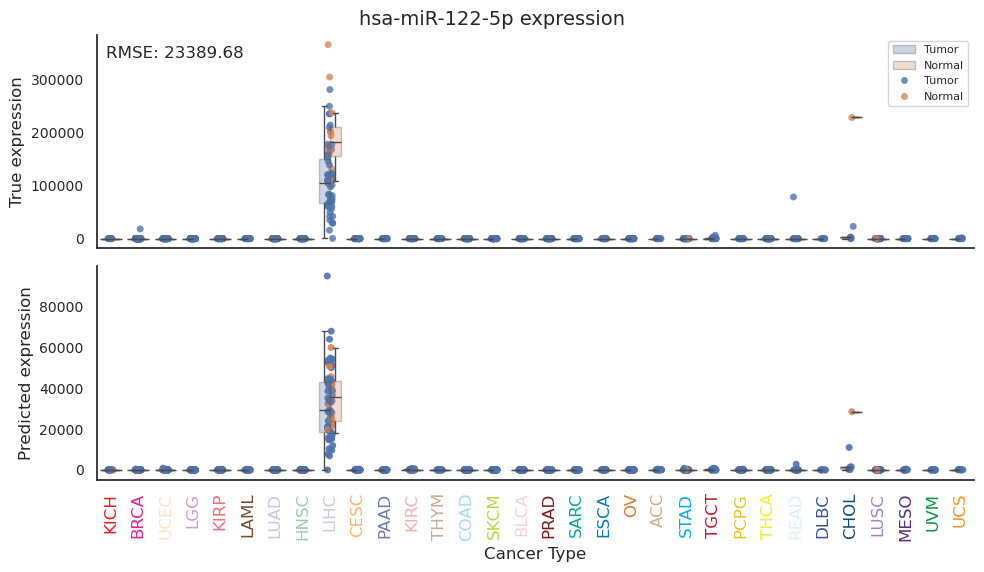

In [532]:
mir = 'hsa-miR-122-5p'
plot_jitter_grouped_tissue(mir, filename=f"jitter {mir}.svg")

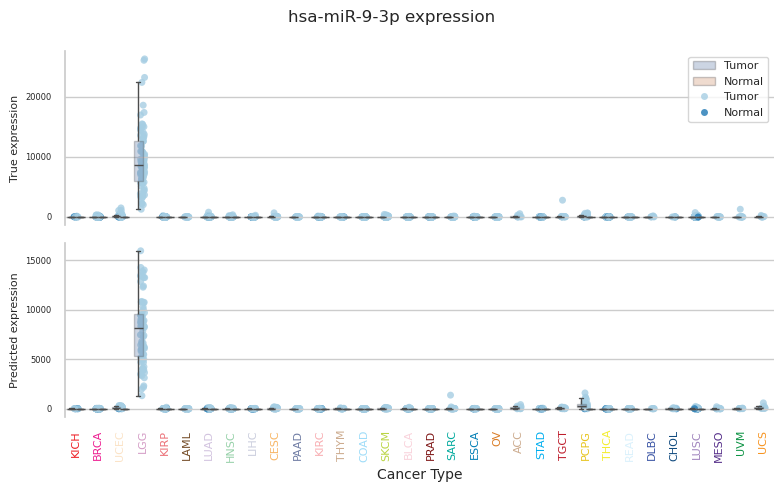

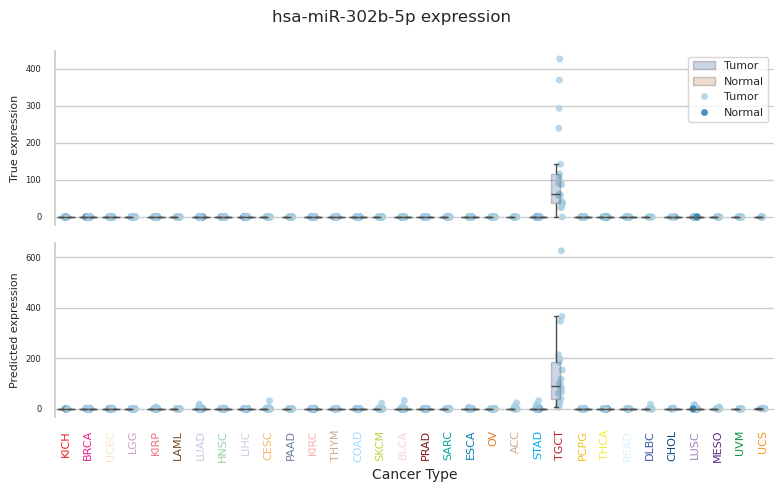

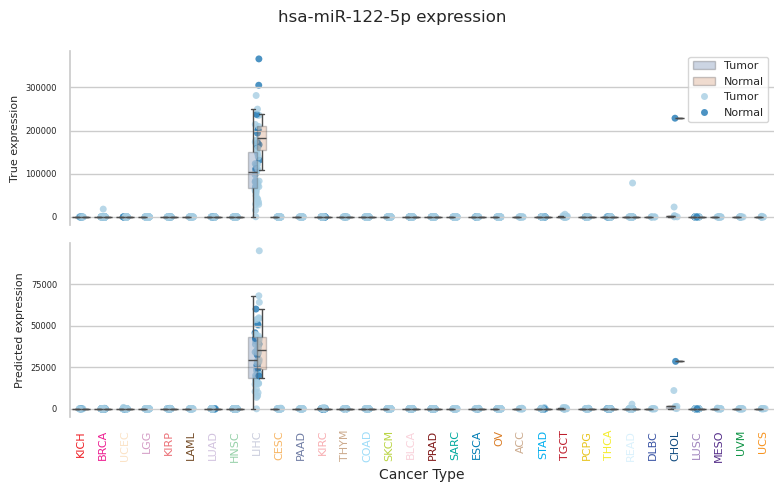

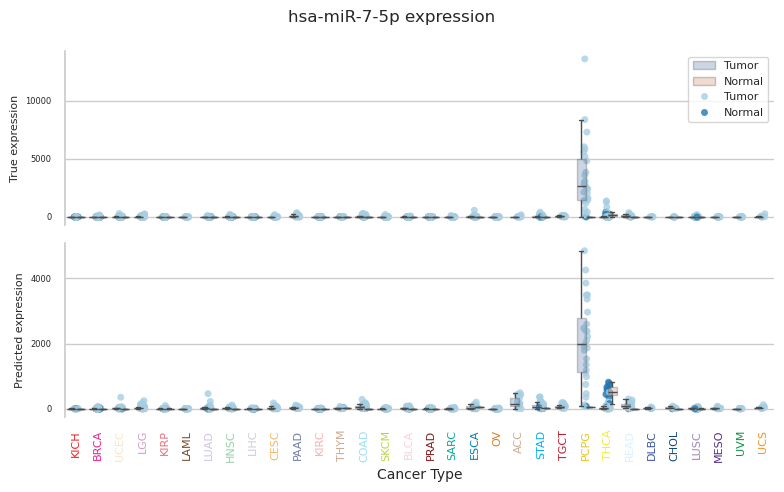

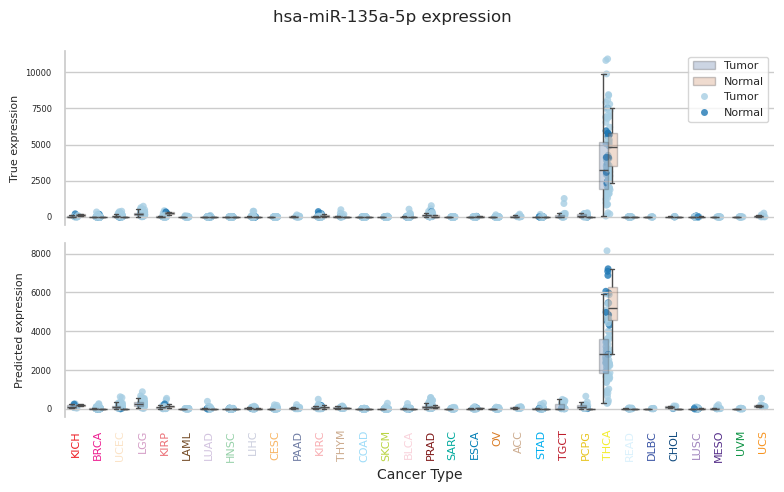

In [162]:
for mir in top_pearson:
    plot_jitter_grouped_tissue(mir, filename=f"jitter {mir} pearson.svg")

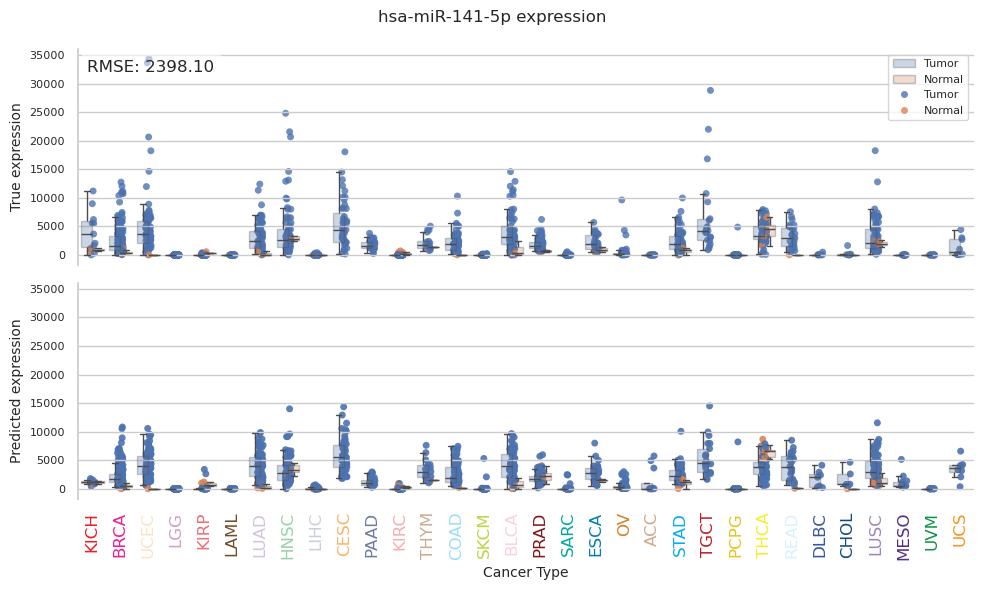

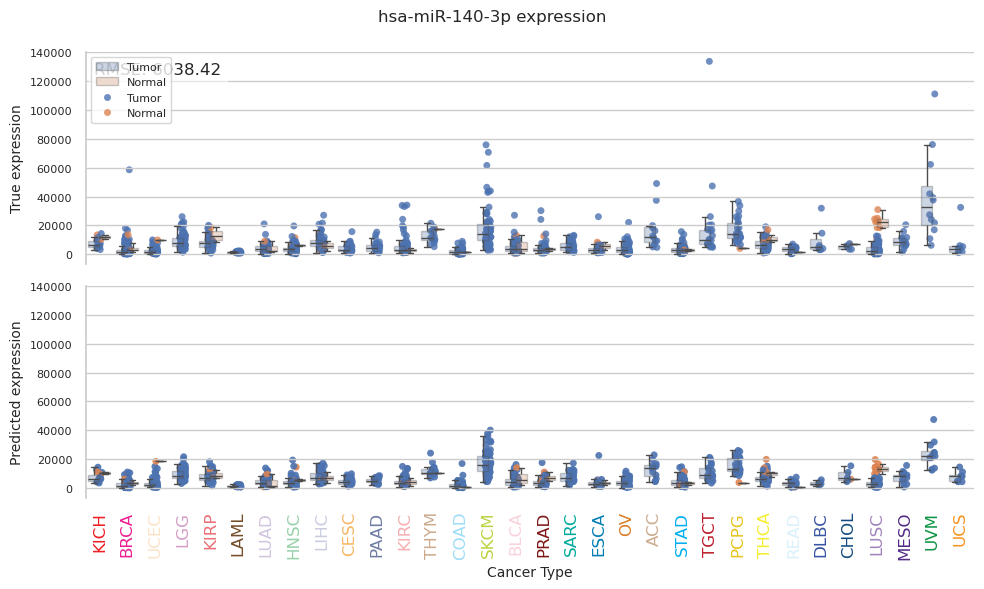

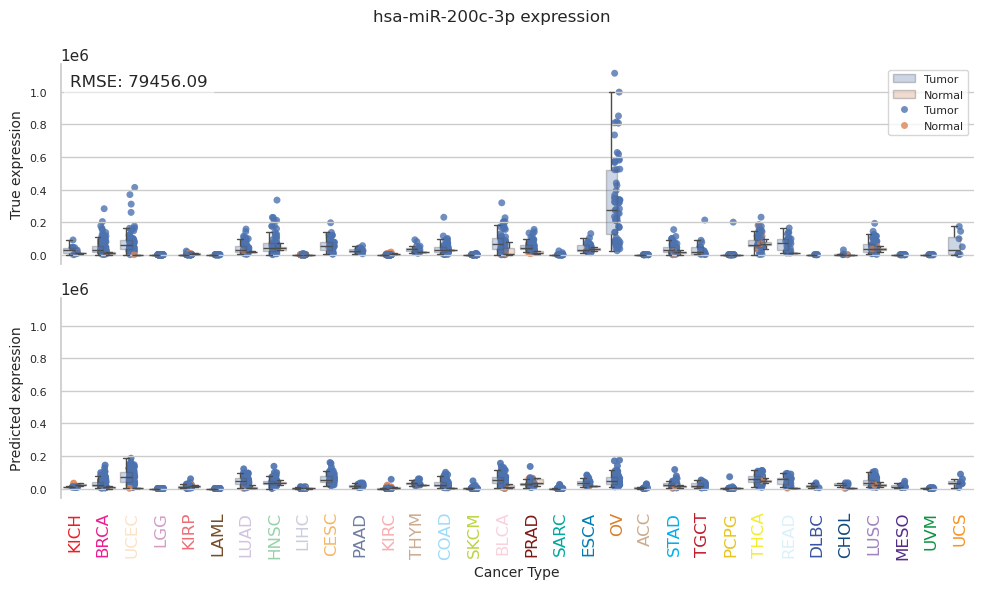

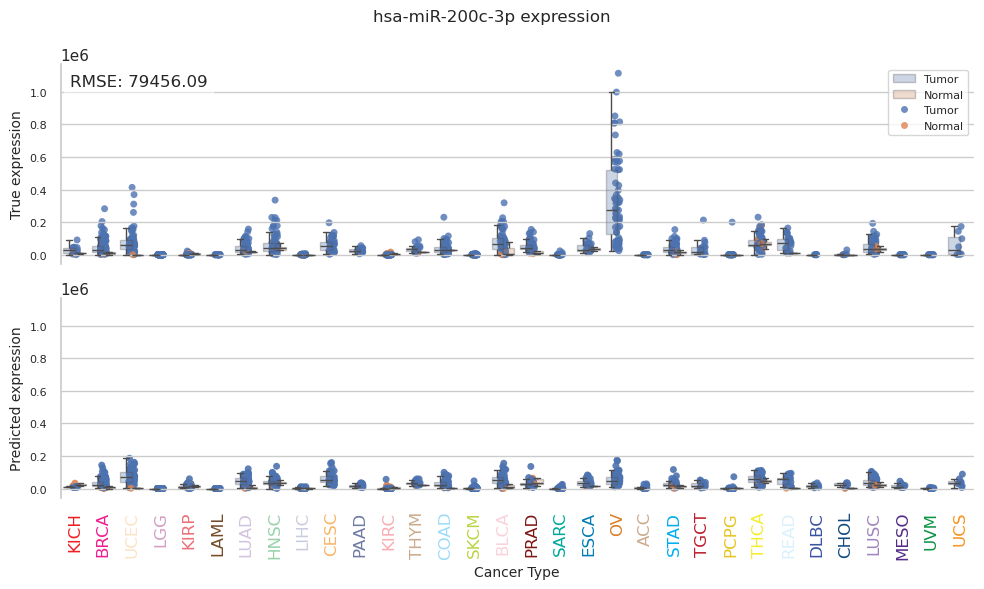

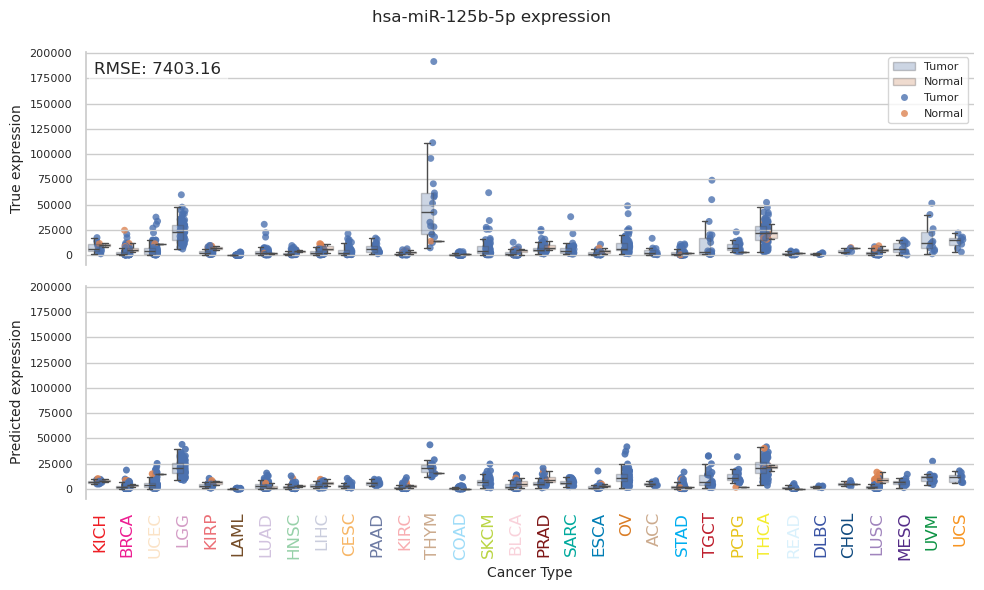

In [494]:
for mir in top_spearman:
    plot_jitter_grouped_tissue(mir, filename=f"jitter {mir} spearman.svg")

In [ ]:
top_mirna = []

# Regression Plot

In [533]:
def regression_plot(subset, cancer_type=None, savedir="plots", filename=None):
    test = get_mirna_data(dgd, data_loader, subset=subset, dataset="test")

    if cancer_type:
        test = test[test['cancer_type'] == cancer_type]
    
    # Set the aesthetic style of the plots
    sns.set_style("white")
    
    # Create a figure to hold the subplots
    plt.figure(figsize=(4, 4))
    # plt.subplots_adjust(vspace=0.1)
    
    # Create scatterplot
    sns.regplot(data=test, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    sns.despine()
    # Calculate Spearman correlation coefficient
    spearman_corr, spearman_p = stats.spearmanr(test['X'], test['y'])
    pearson_corr, pearson_p = stats.pearsonr(test['X'], test['y'])
    # Add correlation coefficient as text annotation
    if spearman_p < 2.2e-16:
        plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = <2.2e-16", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    else:
        plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = {spearman_p:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    if pearson_p < 2.2e-6:
        plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = <2.2e-16", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    else:
        plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = {pearson_p:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    
    plt.xlabel("Predicted expression", fontsize=11)
    plt.ylabel("True expression", fontsize=11)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=10)

    # Add a small dashed diagonal line
    min_val = min(test['X'].min(), test['y'].min())
    max_val = max(test['X'].max(), test['y'].max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='dashed', linewidth=0.5, color='black')
    
    if cancer_type:
        plt.title(f"{subset} in {cancer_type}", fontsize=12, y=1)
    else:
        plt.title(f"{subset} expression", fontsize=12, y=1)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

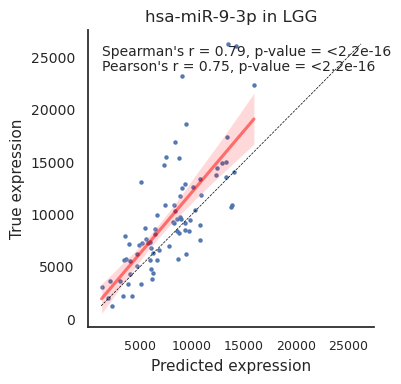

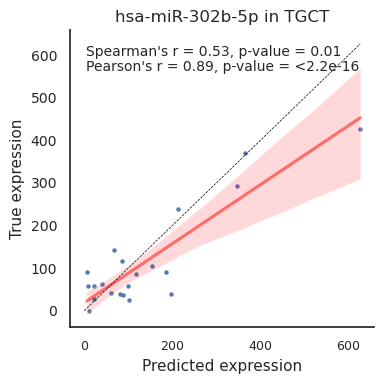

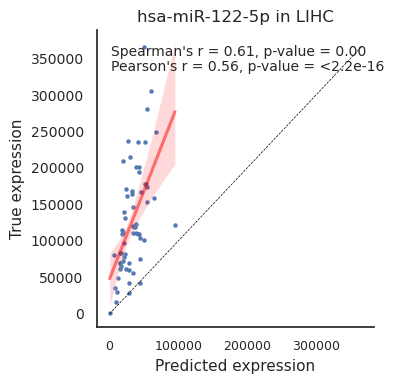

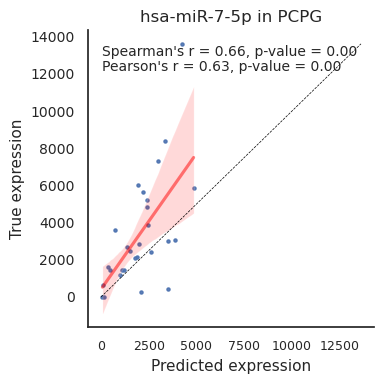

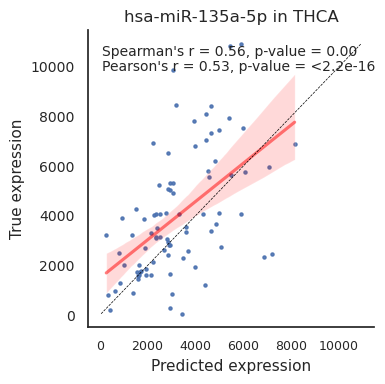

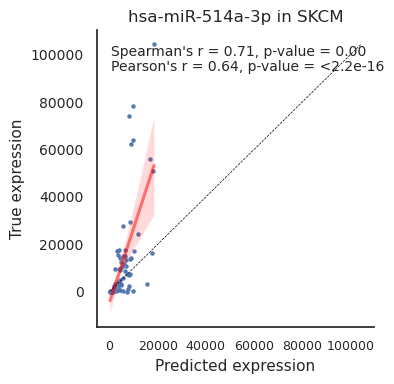

In [534]:
for mir, cancer in zip(top_pearson, top_pearson_cancer):
    regression_plot(mir, cancer, filename=f"regplot {mir} in {cancer}.svg")

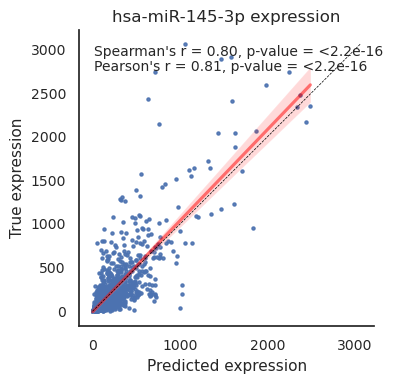

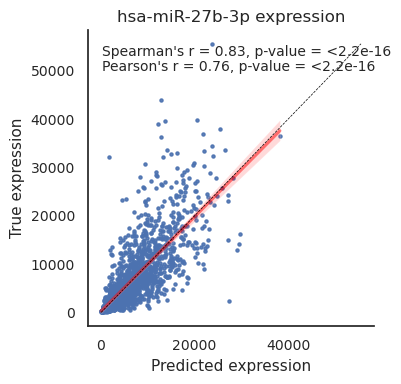

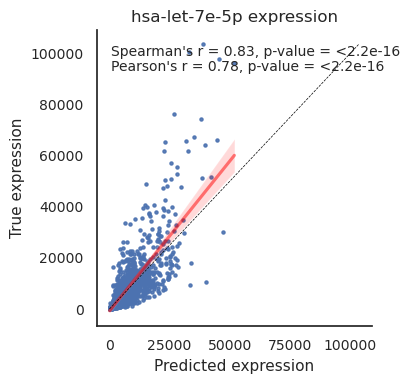

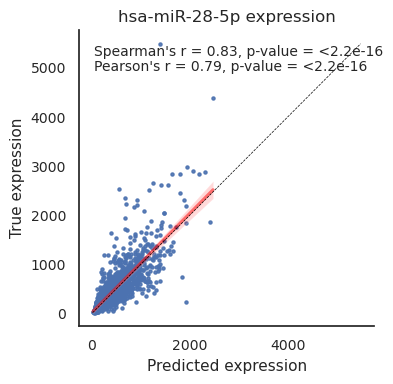

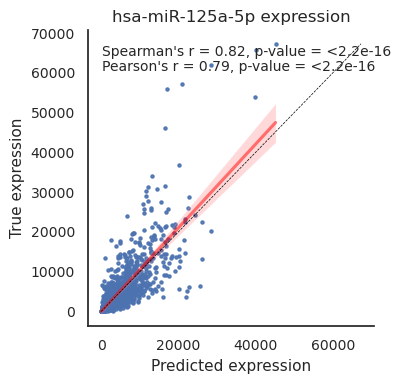

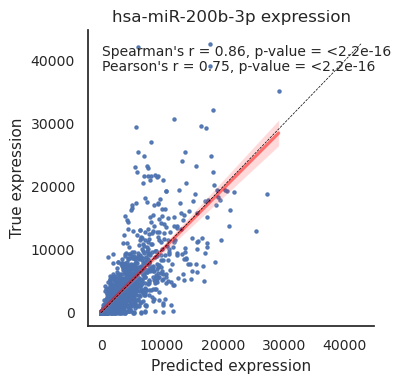

In [523]:
top_mirna = ['hsa-miR-145-3p', 
             'hsa-miR-27b-3p', 
             'hsa-let-7e-5p', 
             'hsa-miR-28-5p', 
             'hsa-miR-125a-5p',
             'hsa-miR-200b-3p']
for mir in top_mirna:
    regression_plot(mir, filename=f"top-regplot {mir}.svg")

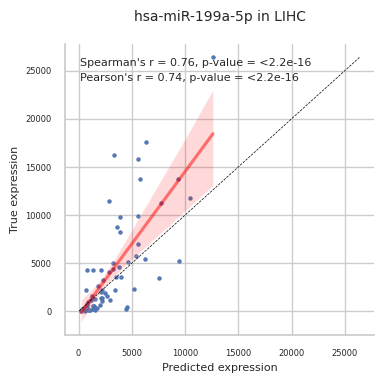

In [468]:
mir = 'hsa-miR-122-5p'
regression_plot(mir, cancer_type='LIHC', filename=f"regplot {mir}.svg")

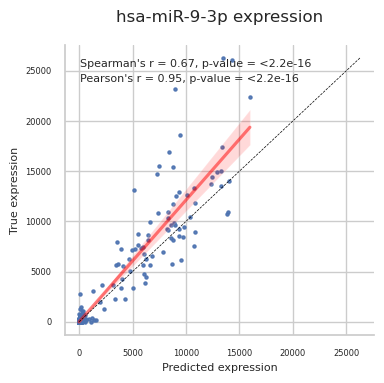

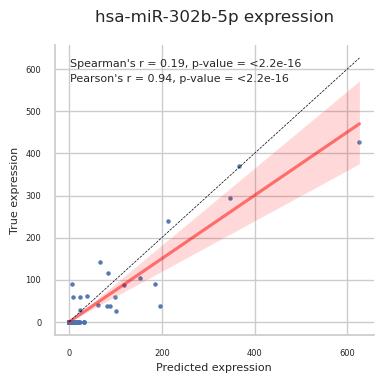

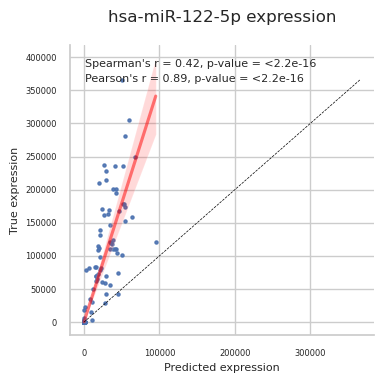

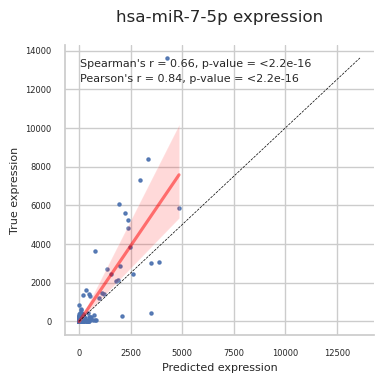

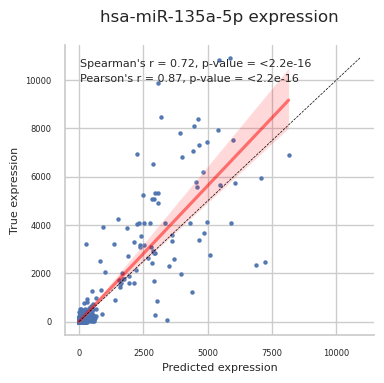

In [375]:
for mir in top_pearson:
    regression_plot(mir, filename=f"top regplot {mir}.svg")

# Regression Plot on Different Sparsity

In [567]:
sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]
exclude = False
if exclude:
    exclude = ["5000", "10000", "50000", "500000", "1000000", "5000000"]
else:
    exclude = []

def regplot_sparsity(dgd, test_rep_load, test_loader, mirna_column, subset, cancer_type=None, savedir="plots", filename=None):
    # Create an empty DataFrame to hold all data
    all_data = pd.DataFrame()
    
    for i, sp in enumerate(sparsity):
        if sp in exclude:
            continue
        X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
        df = pd.DataFrame(
                    data={
                        'X': X.loc[:,subset], 
                        'y': y.loc[:,subset],
                        'cancer_type': X.loc[:,'cancer_type'],
                        'tissue': X.loc[:,'tissue'],
                        'color': X.loc[:,'color'],
                        'sparsity': sp  # Add sparsity as a column
                    }
                )
        all_data = pd.concat([all_data, df], ignore_index=True)

    if cancer_type:
        all_data = all_data[all_data['cancer_type'] == cancer_type]
    
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")
    
    # Create a FacetGrid
    g = sns.FacetGrid(all_data, col="sparsity", col_wrap=3, height=4, aspect=0.9)
    g.map_dataframe(sns.regplot, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    
    # Add correlation coefficients to each facet
    for ax, (name, group) in zip(g.axes.flat, all_data.groupby("sparsity")):
        spearman_corr, spearman_p = stats.spearmanr(group['X'], group['y'])
        pearson_corr, pearson_p = stats.pearsonr(group['X'], group['y'])
        if spearman_p > 2.2e-5:
            ax.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = {spearman_p:.2f}", transform=ax.transAxes, fontsize=8, verticalalignment='top')
            ax.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = {pearson_p:.2f}", transform=ax.transAxes, fontsize=8, verticalalignment='top')
        else:
            ax.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = <2.2e-5", transform=ax.transAxes, fontsize=8, verticalalignment='top')
            ax.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = <2.2e-5", transform=ax.transAxes, fontsize=8, verticalalignment='top')
        # Decrease the size of the ticks and labels
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=6)
    
    g.set_axis_labels("Predicted expression", "True expression")
    g.set_titles(col_template="sparsity {col_name}", size=8)
    
    g.set_xlabels(fontsize=8)
    g.set_ylabels(fontsize=8)
    plt.suptitle(f"{subset} in {cancer_type}", size=12)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

In [542]:
sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]
exclude = True
if exclude:
    exclude = ["5000", "10000", "50000", "500000", "1000000", "5000000"]
else:
    exclude = []
    
def regplot_sparsity(dgd, test_rep_load, test_loader, mirna_column, subset, cancer_type=None, savedir="plots", filename=None):
    # Create an empty DataFrame to hold all data
    all_data = pd.DataFrame()
    
    for i, sp in enumerate(sparsity):
        if sp in exclude:
            continue
        X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
        df = pd.DataFrame(
                    data={
                        'X': X.loc[:,subset], 
                        'y': y.loc[:,subset],
                        'cancer_type': X.loc[:,'cancer_type'],
                        'tissue': X.loc[:,'tissue'],
                        'color': X.loc[:,'color'],
                        'sparsity': sp  # Add sparsity as a column
                    }
                )
        all_data = pd.concat([all_data, df], ignore_index=True)

    if cancer_type:
        all_data = all_data[all_data['cancer_type'] == cancer_type]
    
    # Set the aesthetic style of the plots
    sns.set_style("white")
    
    # Create a FacetGrid
    g = sns.FacetGrid(all_data, col="sparsity", col_wrap=3, height=4, aspect=0.9)
    g.map_dataframe(sns.regplot, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    
    # Add correlation coefficients and diagonal line to each facet
    for ax, (name, group) in zip(g.axes.flat, all_data.groupby("sparsity")):
        spearman_corr, spearman_p = stats.spearmanr(group['X'], group['y'])
        pearson_corr, pearson_p = stats.pearsonr(group['X'], group['y'])
        if spearman_p > 2.2e-10:
            ax.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = {spearman_p:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        else:
            ax.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = <2.2e-10", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        if pearson_p > 2.2e-10:
            ax.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = {pearson_p:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        else:
            ax.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = <2.2e-10", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        # Add a diagonal line x=y
        min_val = min(group['X'].min(), group['y'].min())
        max_val = max(group['X'].max(), group['y'].max())
        ax.plot([min_val, max_val], [min_val, max_val], linestyle='dashed', linewidth=0.5, color='black')
        
        # Decrease the size of the ticks and labels
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        # ax.tick_params(axis='both', which='minor', labelsize=8, rotation=45)
    
    g.set_axis_labels("Predicted expression", "True expression")
    g.set_titles(col_template="reads per sample = {col_name}", size=12)
    
    g.set_xlabels(fontsize=11)
    g.set_ylabels(fontsize=11)
    if cancer_type:
        plt.suptitle(f"{subset} in {cancer_type}", size=16)
    else:
        plt.suptitle(f"{subset}", size=16)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

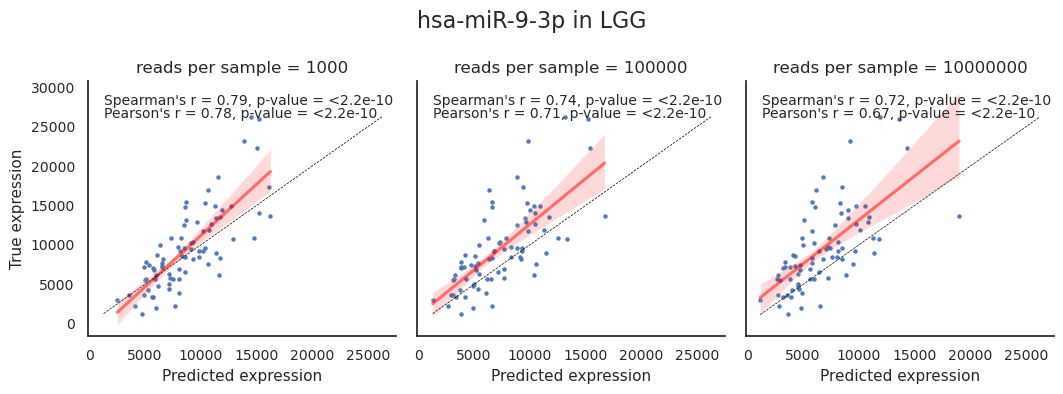

In [546]:
# Example usage
mir = 'hsa-miR-9-3p'

regplot_sparsity(dgd, test_rep_load, test_loader, mirna_column, mir, cancer_type='LGG', filename=f"regplot_facet {mir}.svg")

# Joint Plot

In [547]:
def joint_plot(subset):
    data = get_mirna_data(dgd, data_loader, subset=subset)
    
    g = sns.JointGrid(data=data, x="X", y="y", hue='tissue', height=6, ratio=6,
                     xlim=(0, 10000), ylim=(0, 10000))
    g.plot_joint(sns.scatterplot, s=20)
    g.plot_marginals(sns.rugplot, height=.5)
    g.set_axis_labels("Predicted exp", "True exp")
    plt.tight_layout()
    plt.show()

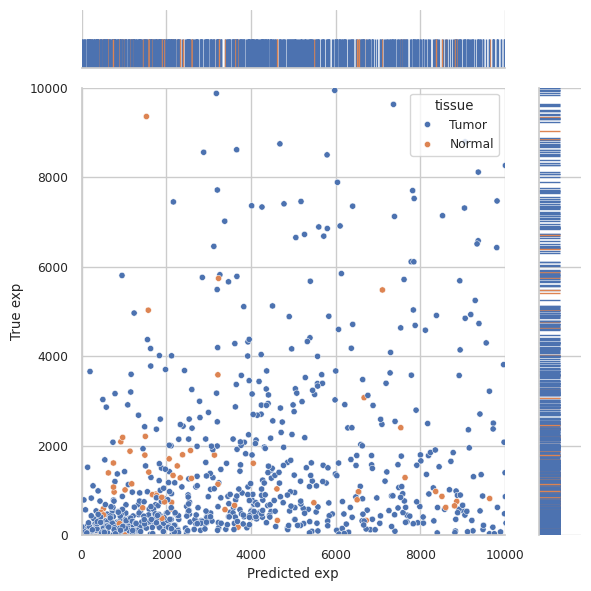

In [548]:
joint_plot('hsa-miR-9-5p')

# Training loss

In [7]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns

mrna_loss = torch.load('results/final_loss_mrna.pickle')
mirna_loss = torch.load('results/final_loss_mirna.pickle')

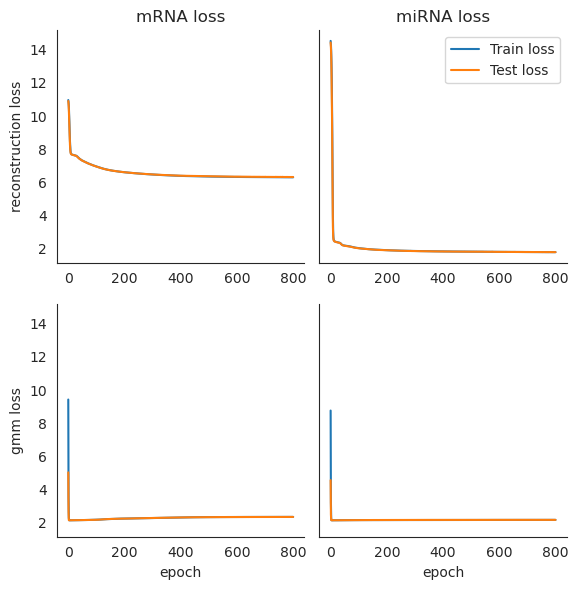

In [12]:
# Set the aesthetic style of the plots
sns.set_style("white")

# Create a figure to hold the subplots with shared y-axis
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True)
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss (mRNA)
sns.lineplot(ax=axes[0, 0], x="epoch", y="train_recon", data=mrna_loss, label="Train loss")
sns.lineplot(ax=axes[0, 0], x="epoch", y="test_recon", data=mrna_loss, label="Test loss")
axes[0, 0].set_title("mRNA loss")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("reconstruction loss")
axes[0, 0].legend().remove()

# Second subplot for Reconstruction loss (miRNA)
sns.lineplot(ax=axes[0, 1], x="epoch", y="train_recon", data=mirna_loss, label="Train loss")
sns.lineplot(ax=axes[0, 1], x="epoch", y="test_recon", data=mirna_loss, label="Test loss")
axes[0, 1].set_title("miRNA loss")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

# Third subplot for GMM loss (mRNA)
sns.lineplot(ax=axes[1, 0], x="epoch", y="train_gmm", data=mrna_loss, label="Train loss")
sns.lineplot(ax=axes[1, 0], x="epoch", y="test_gmm", data=mrna_loss, label="Test loss")
axes[1, 0].set_title("")
axes[1, 0].set_xlabel("epoch")
axes[1, 0].set_ylabel("gmm loss")
axes[1, 0].legend().remove()

# Fourth subplot for GMM loss (miRNA)
sns.lineplot(ax=axes[1, 1], x="epoch", y="train_gmm", data=mirna_loss, label="Train loss")
sns.lineplot(ax=axes[1, 1], x="epoch", y="test_gmm", data=mirna_loss, label="Test loss")
axes[1, 1].set_title("")
axes[1, 1].set_xlabel("epoch")
axes[1, 1].set_ylabel("")
axes[1, 1].set_ylabel("")
axes[1, 1].legend().remove()

# Display the plots
plt.tight_layout()
sns.despine()
plt.savefig(os.path.join("plots", "Training loss metrics single.pdf"))
plt.show()